##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST の分類

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/quantum/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/quantum/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/quantum/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

このチュートリアルでは、簡略化された MNIST バージョンを分類する、<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a> で使用されたアプローチに似た量子ニューラルネットワーク（QNN）を構築し、古典的なデータ問題における量子ニューラルネットワークのパフォーマンスを従来のニューラルネットワークと比較します。

## セットアップ

In [2]:
!pip install -q tensorflow==2.3.1

TensorFlow Quantum をインストールします。

In [3]:
!pip install -q tensorflow-quantum

次に、TensorFlow とモジュールの依存関係をインポートします。

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. データを読み込む

このチュートリアルでは、<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> に従って、数字の 3 と 6 を区別する二項分類器を構築します。このセクションでは、次を行うデータ処理を説明します。

- Keras から生データを読み込みます。
- データセットを 3 と 6 に絞り込みます。
- 画像が量子コンピュータに適合するように、画像を縮小します。
- 矛盾するサンプルを取り除きます。
- バイナリ画像を Cirq 回路に変換します。
- Cirq 回路を TensorFlow Quantum 回路に変換します。 

### 1.1 生データを読み込む

Keras で配布された MNIST データセットを読み込みます。 

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


3 と 6 の数字のみを保持してほかのクラスを取り除くように、データセットを絞り込みます。同時に、`3` を `True`、6 を `False` というように、ラベル `y` をブール型に変換します。 

In [6]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [7]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


最初のサンプルを表示します。

True


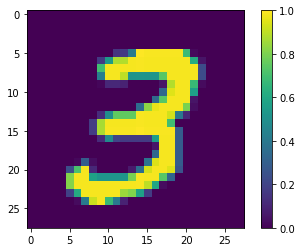

In [8]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 画像を縮小する

現在の量子コンピュータでは、画像サイズ 28x28 は大きすぎるため、4x4 に縮小します。

In [9]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

サイズ変更を行ったら、もう一度最初のサンプルを表示します。 

True


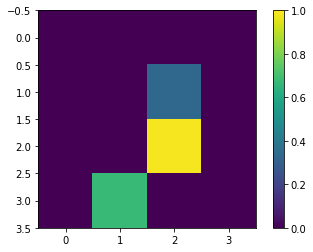

In [10]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 矛盾するサンプルを取り除く

<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> の *3.3 Learning to Distinguish Digits* セクションに説明されているように、データセットから両方のクラスに属するラベルが付けられた画像を取り除きます。

これは標準的な機械学習の手順ではありませんが、論文の手順に従う目的で追加している手順です。

In [11]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

取り除いた結果の数量は、レポートされている値に密に一致していませんが、これは正確な手順が指定されていないためです。

また、この時点で、矛盾するサンプルをフィルタリングすることで、矛盾するトレーニングサンプルがモデルに絶対に送られないということではありません。次のデータの二項化のステップでは、さらに競合が発生します。 

In [12]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


### 1.3 データを量子回路としてエンコードする

<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、量子コンピュータを使って画像を処理するには、ピクセルの値に応じた状態で、各ピクセルをキュービットで表現するように提案しています。最初のステップでは、バイナリエンコーディングへの変換を行います。

In [13]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

この時点で矛盾した画像を取り除く場合、193 個しか画像が残らず、これでは有効なトレーニングを行える数量とは言えません。

In [14]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of 3s:  124
Number of 6s:  113
Number of contradictory images:  44

Initial number of examples:  11520
Remaining non-contradictory examples:  3731


しきい値を超える値を持つピクセルインデックスのキュービットは、$X$ ゲートを介して循環します。

In [15]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

これは最初のサンプルに作成された回路です（回路図には、ゼロゲートのキュービットは表示されていません）。

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


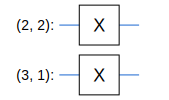

In [16]:
SVGCircuit(x_train_circ[0])

この回路を、画像の値がしきい値を超えるインデックスを比較します。

In [17]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

これらの `Cirq` 回路を `tfq` のテンソルに変換します。

In [18]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. 量子ニューラルネットワーク

画像を分類する量子回路構造に関するガイダンスはほとんどありません。分類は読み出されるキュービットの期待に基づいて行われるため、<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、2 つのキュービットゲートを使用して、読み出しキュービットが必ず作用されるようにすることを提案しています。これはある意味、ピクセル全体に小さな<a href="https://arxiv.org/abs/1511.06464" class="external">ユニタリ RNN</a>を実行することに似ています。

### 2.1 モデル回路を構築する

次の例では、このレイヤー化アプローチを説明しています。各レイヤーは同一ゲートの *n* 個のインスタンスを使用しており、各データキュービットは読み出しキュービットに影響を与えています。

ゲートのレイヤーを回路に追加する簡単なクラスから始めましょう。

In [19]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

サンプル回路レイヤーを構築して、どのようになるかを確認します。

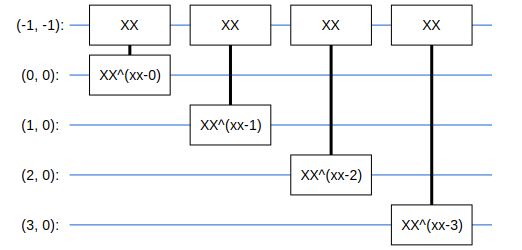

In [20]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

では、2 レイヤーモデルを構築しましょう。 データ回路サイズに一致するようにし、準備と読み出し演算を含めます。

In [21]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [22]:
model_circuit, model_readout = create_quantum_model()

### 2.2 tfq-keras モデルでモデル回路をラップする

量子コンポーネントで Keras モデルを構築します。このモデルには、古典的なデータをエンコードする「量子データ」が `x_train_circ` からフィードされます。*パラメータ化された量子回路*レイヤーの `tfq.layers.PQC` を使用して、量子データでモデル回路をトレーニングするモデルです。

<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、画像を分類するには、パラメータ化された回路で読み出しキュービットの期待値を使用することを提案しています。期待値は、1 から -1 の値です。

In [23]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

次に、`compile` メソッドを使用して、モデルにトレーニング手順を指定します。

期待される読み出しは `[-1,1]` の範囲であるため、ヒンジ損失を最適化すると、ある程度自然な適合となります。

注意: もう 1 つの有効なアプローチとして、出力範囲を `[0,1]` にシフトし、モデルがクラス `3` に割りてる確率として扱う方法があります。これは、標準的な`tf.losses.BinaryCrossentropy` 損失で使用することができます。

ここでヒンジ損失を使用するには、小さな調整を 2 つ行う必要があります。まず、ラベル `y_train_nocon` をブール型からヒンジ損失が期待する `[-1,1]` に変換することです。

In [24]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

次に、`[-1, 1]` を `y_true` ラベル引数として正しく処理するカスタムの `hinge_accuracy` メトリックを使用します。`tf.losses.BinaryAccuracy(threshold=0.0)` は `y_true` がブール型であることを期待するため、ヒンジ損失とは使用できません。

In [25]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [26]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### 量子モデルをトレーニングする

では、モデルをトレーニングしましょう。これには約 45 分かかりますが、その時間を待てない方は、小規模なデータのサブセット（以下の`NUM_EXAMPLES=500` セット）を使用するとよいでしょう。トレーニング時のモデルの進捗にあまり影響はありません（パラメータは 32 しかなく、これらを制約する上であまりデータは必要ありません）。サンプル数を減らすことでトレーニングを早めに（5 分程度）終わらせることができますが、検証ログに進捗状況を示すには十分な長さです。

In [28]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [29]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

このモデルを収束までトレーニングすると、テストセットにおいて 85% を超える精度が達成されます。

In [30]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3


  1/360 [..............................] - ETA: 0s - loss: 0.9947 - hinge_accuracy: 0.5938

  2/360 [..............................] - ETA: 1:16 - loss: 0.9937 - hinge_accuracy: 0.5625

  3/360 [..............................] - ETA: 1:42 - loss: 0.9981 - hinge_accuracy: 0.5104

  4/360 [..............................] - ETA: 1:54 - loss: 0.9956 - hinge_accuracy: 0.5469

  5/360 [..............................] - ETA: 2:01 - loss: 0.9944 - hinge_accuracy: 0.5562

  6/360 [..............................] - ETA: 2:06 - loss: 0.9937 - hinge_accuracy: 0.5573

  7/360 [..............................] - ETA: 2:10 - loss: 0.9936 - hinge_accuracy: 0.5580

  8/360 [..............................] - ETA: 2:12 - loss: 0.9933 - hinge_accuracy: 0.5586

  9/360 [..............................] - ETA: 2:14 - loss: 0.9930 - hinge_accuracy: 0.5625

 10/360 [..............................] - ETA: 2:15 - loss: 0.9929 - hinge_accuracy: 0.5625

 11/360 [..............................] - ETA: 2:16 - loss: 0.9933 - hinge_accuracy: 0.5568

 12/360 [>.............................] - ETA: 2:17 - loss: 0.9923 - hinge_accuracy: 0.5729

 13/360 [>.............................] - ETA: 2:17 - loss: 0.9918 - hinge_accuracy: 0.5841

 14/360 [>.............................] - ETA: 2:17 - loss: 0.9918 - hinge_accuracy: 0.5893

 15/360 [>.............................] - ETA: 2:18 - loss: 0.9907 - hinge_accuracy: 0.6042

 16/360 [>.............................] - ETA: 2:18 - loss: 0.9903 - hinge_accuracy: 0.6094

 17/360 [>.............................] - ETA: 2:18 - loss: 0.9900 - hinge_accuracy: 0.6121

 18/360 [>.............................] - ETA: 2:19 - loss: 0.9894 - hinge_accuracy: 0.6181

 19/360 [>.............................] - ETA: 2:19 - loss: 0.9890 - hinge_accuracy: 0.6250

 20/360 [>.............................] - ETA: 2:19 - loss: 0.9881 - hinge_accuracy: 0.6297

 21/360 [>.............................] - ETA: 2:19 - loss: 0.9876 - hinge_accuracy: 0.6339

 22/360 [>.............................] - ETA: 2:18 - loss: 0.9873 - hinge_accuracy: 0.6364

 23/360 [>.............................] - ETA: 2:18 - loss: 0.9874 - hinge_accuracy: 0.6372

 24/360 [=>............................] - ETA: 2:18 - loss: 0.9864 - hinge_accuracy: 0.6432

 25/360 [=>............................] - ETA: 2:18 - loss: 0.9857 - hinge_accuracy: 0.6463

 26/360 [=>............................] - ETA: 2:18 - loss: 0.9850 - hinge_accuracy: 0.6514

 27/360 [=>............................] - ETA: 2:17 - loss: 0.9850 - hinge_accuracy: 0.6505

 28/360 [=>............................] - ETA: 2:17 - loss: 0.9842 - hinge_accuracy: 0.6540

 29/360 [=>............................] - ETA: 2:17 - loss: 0.9835 - hinge_accuracy: 0.6584

 30/360 [=>............................] - ETA: 2:17 - loss: 0.9834 - hinge_accuracy: 0.6594

 31/360 [=>............................] - ETA: 2:17 - loss: 0.9835 - hinge_accuracy: 0.6573

 32/360 [=>............................] - ETA: 2:16 - loss: 0.9835 - hinge_accuracy: 0.6562

 33/360 [=>............................] - ETA: 2:16 - loss: 0.9834 - hinge_accuracy: 0.6544

 34/360 [=>............................] - ETA: 2:16 - loss: 0.9833 - hinge_accuracy: 0.6544

 35/360 [=>............................] - ETA: 2:16 - loss: 0.9827 - hinge_accuracy: 0.6571

 36/360 [==>...........................] - ETA: 2:15 - loss: 0.9825 - hinge_accuracy: 0.6562

 37/360 [==>...........................] - ETA: 2:15 - loss: 0.9822 - hinge_accuracy: 0.6554

 38/360 [==>...........................] - ETA: 2:15 - loss: 0.9821 - hinge_accuracy: 0.6546

 39/360 [==>...........................] - ETA: 2:14 - loss: 0.9819 - hinge_accuracy: 0.6546

 40/360 [==>...........................] - ETA: 2:14 - loss: 0.9810 - hinge_accuracy: 0.6586

 41/360 [==>...........................] - ETA: 2:13 - loss: 0.9805 - hinge_accuracy: 0.6593

 42/360 [==>...........................] - ETA: 2:13 - loss: 0.9802 - hinge_accuracy: 0.6585

 43/360 [==>...........................] - ETA: 2:13 - loss: 0.9798 - hinge_accuracy: 0.6599

 44/360 [==>...........................] - ETA: 2:12 - loss: 0.9797 - hinge_accuracy: 0.6591

 45/360 [==>...........................] - ETA: 2:12 - loss: 0.9792 - hinge_accuracy: 0.6604

 46/360 [==>...........................] - ETA: 2:12 - loss: 0.9786 - hinge_accuracy: 0.6617

 47/360 [==>...........................] - ETA: 2:11 - loss: 0.9777 - hinge_accuracy: 0.6642

 48/360 [===>..........................] - ETA: 2:11 - loss: 0.9775 - hinge_accuracy: 0.6628

 49/360 [===>..........................] - ETA: 2:10 - loss: 0.9767 - hinge_accuracy: 0.6639

 50/360 [===>..........................] - ETA: 2:10 - loss: 0.9762 - hinge_accuracy: 0.6644

 51/360 [===>..........................] - ETA: 2:10 - loss: 0.9764 - hinge_accuracy: 0.6624

 52/360 [===>..........................] - ETA: 2:09 - loss: 0.9761 - hinge_accuracy: 0.6641

 53/360 [===>..........................] - ETA: 2:09 - loss: 0.9757 - hinge_accuracy: 0.6633

 54/360 [===>..........................] - ETA: 2:09 - loss: 0.9747 - hinge_accuracy: 0.6667

 55/360 [===>..........................] - ETA: 2:08 - loss: 0.9743 - hinge_accuracy: 0.6682

 56/360 [===>..........................] - ETA: 2:08 - loss: 0.9736 - hinge_accuracy: 0.6708

 57/360 [===>..........................] - ETA: 2:07 - loss: 0.9726 - hinge_accuracy: 0.6743

 58/360 [===>..........................] - ETA: 2:07 - loss: 0.9729 - hinge_accuracy: 0.6724

 59/360 [===>..........................] - ETA: 2:06 - loss: 0.9724 - hinge_accuracy: 0.6743

 60/360 [====>.........................] - ETA: 2:06 - loss: 0.9719 - hinge_accuracy: 0.6750

 61/360 [====>.........................] - ETA: 2:05 - loss: 0.9714 - hinge_accuracy: 0.6762

 62/360 [====>.........................] - ETA: 2:05 - loss: 0.9709 - hinge_accuracy: 0.6769

 63/360 [====>.........................] - ETA: 2:05 - loss: 0.9704 - hinge_accuracy: 0.6781

 64/360 [====>.........................] - ETA: 2:04 - loss: 0.9701 - hinge_accuracy: 0.6772

 65/360 [====>.........................] - ETA: 2:04 - loss: 0.9696 - hinge_accuracy: 0.6784

 66/360 [====>.........................] - ETA: 2:03 - loss: 0.9688 - hinge_accuracy: 0.6809

 67/360 [====>.........................] - ETA: 2:03 - loss: 0.9685 - hinge_accuracy: 0.6824

 68/360 [====>.........................] - ETA: 2:03 - loss: 0.9678 - hinge_accuracy: 0.6829

 69/360 [====>.........................] - ETA: 2:02 - loss: 0.9671 - hinge_accuracy: 0.6843

 70/360 [====>.........................] - ETA: 2:02 - loss: 0.9668 - hinge_accuracy: 0.6848

 71/360 [====>.........................] - ETA: 2:01 - loss: 0.9662 - hinge_accuracy: 0.6849

 72/360 [=====>........................] - ETA: 2:01 - loss: 0.9658 - hinge_accuracy: 0.6845

 73/360 [=====>........................] - ETA: 2:01 - loss: 0.9656 - hinge_accuracy: 0.6836

 74/360 [=====>........................] - ETA: 2:00 - loss: 0.9645 - hinge_accuracy: 0.6858

 75/360 [=====>........................] - ETA: 2:00 - loss: 0.9636 - hinge_accuracy: 0.6871

 76/360 [=====>........................] - ETA: 1:59 - loss: 0.9627 - hinge_accuracy: 0.6883

 77/360 [=====>........................] - ETA: 1:59 - loss: 0.9627 - hinge_accuracy: 0.6871

 78/360 [=====>........................] - ETA: 1:59 - loss: 0.9621 - hinge_accuracy: 0.6875

 79/360 [=====>........................] - ETA: 1:58 - loss: 0.9611 - hinge_accuracy: 0.6891

 80/360 [=====>........................] - ETA: 1:58 - loss: 0.9600 - hinge_accuracy: 0.6895

 81/360 [=====>........................] - ETA: 1:57 - loss: 0.9590 - hinge_accuracy: 0.6898

 82/360 [=====>........................] - ETA: 1:57 - loss: 0.9584 - hinge_accuracy: 0.6898

 83/360 [=====>........................] - ETA: 1:57 - loss: 0.9576 - hinge_accuracy: 0.6905

 84/360 [======>.......................] - ETA: 1:56 - loss: 0.9570 - hinge_accuracy: 0.6908

 85/360 [======>.......................] - ETA: 1:56 - loss: 0.9568 - hinge_accuracy: 0.6893

 86/360 [======>.......................] - ETA: 1:55 - loss: 0.9559 - hinge_accuracy: 0.6897

 87/360 [======>.......................] - ETA: 1:55 - loss: 0.9553 - hinge_accuracy: 0.6904

 88/360 [======>.......................] - ETA: 1:55 - loss: 0.9546 - hinge_accuracy: 0.6911

 89/360 [======>.......................] - ETA: 1:54 - loss: 0.9532 - hinge_accuracy: 0.6921

 90/360 [======>.......................] - ETA: 1:54 - loss: 0.9524 - hinge_accuracy: 0.6927

 91/360 [======>.......................] - ETA: 1:53 - loss: 0.9512 - hinge_accuracy: 0.6937

 92/360 [======>.......................] - ETA: 1:53 - loss: 0.9509 - hinge_accuracy: 0.6933

 93/360 [======>.......................] - ETA: 1:52 - loss: 0.9497 - hinge_accuracy: 0.6942

 94/360 [======>.......................] - ETA: 1:52 - loss: 0.9487 - hinge_accuracy: 0.6951

 95/360 [======>.......................] - ETA: 1:52 - loss: 0.9478 - hinge_accuracy: 0.6961

 96/360 [=======>......................] - ETA: 1:51 - loss: 0.9467 - hinge_accuracy: 0.6973

 97/360 [=======>......................] - ETA: 1:51 - loss: 0.9459 - hinge_accuracy: 0.6975

 98/360 [=======>......................] - ETA: 1:50 - loss: 0.9447 - hinge_accuracy: 0.6987

 99/360 [=======>......................] - ETA: 1:50 - loss: 0.9438 - hinge_accuracy: 0.6998

100/360 [=======>......................] - ETA: 1:50 - loss: 0.9423 - hinge_accuracy: 0.7006

101/360 [=======>......................] - ETA: 1:49 - loss: 0.9405 - hinge_accuracy: 0.7027

102/360 [=======>......................] - ETA: 1:49 - loss: 0.9388 - hinge_accuracy: 0.7040

103/360 [=======>......................] - ETA: 1:48 - loss: 0.9370 - hinge_accuracy: 0.7057

104/360 [=======>......................] - ETA: 1:48 - loss: 0.9366 - hinge_accuracy: 0.7043

105/360 [=======>......................] - ETA: 1:48 - loss: 0.9352 - hinge_accuracy: 0.7045

106/360 [=======>......................] - ETA: 1:47 - loss: 0.9337 - hinge_accuracy: 0.7055

107/360 [=======>......................] - ETA: 1:47 - loss: 0.9324 - hinge_accuracy: 0.7059

108/360 [========>.....................] - ETA: 1:46 - loss: 0.9314 - hinge_accuracy: 0.7057

109/360 [========>.....................] - ETA: 1:46 - loss: 0.9302 - hinge_accuracy: 0.7067

110/360 [========>.....................] - ETA: 1:45 - loss: 0.9291 - hinge_accuracy: 0.7077

111/360 [========>.....................] - ETA: 1:45 - loss: 0.9277 - hinge_accuracy: 0.7089

112/360 [========>.....................] - ETA: 1:45 - loss: 0.9272 - hinge_accuracy: 0.7093

113/360 [========>.....................] - ETA: 1:44 - loss: 0.9264 - hinge_accuracy: 0.7088

114/360 [========>.....................] - ETA: 1:44 - loss: 0.9251 - hinge_accuracy: 0.7100

115/360 [========>.....................] - ETA: 1:43 - loss: 0.9238 - hinge_accuracy: 0.7109

116/360 [========>.....................] - ETA: 1:43 - loss: 0.9223 - hinge_accuracy: 0.7117

117/360 [========>.....................] - ETA: 1:42 - loss: 0.9209 - hinge_accuracy: 0.7126

118/360 [========>.....................] - ETA: 1:42 - loss: 0.9194 - hinge_accuracy: 0.7137

119/360 [========>.....................] - ETA: 1:42 - loss: 0.9184 - hinge_accuracy: 0.7143

120/360 [=========>....................] - ETA: 1:41 - loss: 0.9168 - hinge_accuracy: 0.7156

121/360 [=========>....................] - ETA: 1:41 - loss: 0.9152 - hinge_accuracy: 0.7167

122/360 [=========>....................] - ETA: 1:40 - loss: 0.9145 - hinge_accuracy: 0.7164

123/360 [=========>....................] - ETA: 1:40 - loss: 0.9141 - hinge_accuracy: 0.7165

124/360 [=========>....................] - ETA: 1:39 - loss: 0.9130 - hinge_accuracy: 0.7160

125/360 [=========>....................] - ETA: 1:39 - loss: 0.9124 - hinge_accuracy: 0.7165

126/360 [=========>....................] - ETA: 1:39 - loss: 0.9112 - hinge_accuracy: 0.7175

127/360 [=========>....................] - ETA: 1:38 - loss: 0.9098 - hinge_accuracy: 0.7180

128/360 [=========>....................] - ETA: 1:38 - loss: 0.9086 - hinge_accuracy: 0.7183

129/360 [=========>....................] - ETA: 1:37 - loss: 0.9073 - hinge_accuracy: 0.7192

130/360 [=========>....................] - ETA: 1:37 - loss: 0.9061 - hinge_accuracy: 0.7200

131/360 [=========>....................] - ETA: 1:36 - loss: 0.9043 - hinge_accuracy: 0.7214

132/360 [==========>...................] - ETA: 1:36 - loss: 0.9028 - hinge_accuracy: 0.7223

133/360 [==========>...................] - ETA: 1:36 - loss: 0.9015 - hinge_accuracy: 0.7232

134/360 [==========>...................] - ETA: 1:35 - loss: 0.9000 - hinge_accuracy: 0.7243

135/360 [==========>...................] - ETA: 1:35 - loss: 0.8986 - hinge_accuracy: 0.7255

136/360 [==========>...................] - ETA: 1:34 - loss: 0.8972 - hinge_accuracy: 0.7263

137/360 [==========>...................] - ETA: 1:34 - loss: 0.8953 - hinge_accuracy: 0.7274

138/360 [==========>...................] - ETA: 1:33 - loss: 0.8938 - hinge_accuracy: 0.7280

139/360 [==========>...................] - ETA: 1:33 - loss: 0.8919 - hinge_accuracy: 0.7295

140/360 [==========>...................] - ETA: 1:33 - loss: 0.8901 - hinge_accuracy: 0.7310

141/360 [==========>...................] - ETA: 1:32 - loss: 0.8886 - hinge_accuracy: 0.7323

142/360 [==========>...................] - ETA: 1:32 - loss: 0.8864 - hinge_accuracy: 0.7337

143/360 [==========>...................] - ETA: 1:31 - loss: 0.8843 - hinge_accuracy: 0.7349

144/360 [===========>..................] - ETA: 1:31 - loss: 0.8827 - hinge_accuracy: 0.7357

145/360 [===========>..................] - ETA: 1:31 - loss: 0.8813 - hinge_accuracy: 0.7360

146/360 [===========>..................] - ETA: 1:30 - loss: 0.8796 - hinge_accuracy: 0.7369

147/360 [===========>..................] - ETA: 1:30 - loss: 0.8777 - hinge_accuracy: 0.7383

148/360 [===========>..................] - ETA: 1:29 - loss: 0.8758 - hinge_accuracy: 0.7397

149/360 [===========>..................] - ETA: 1:29 - loss: 0.8741 - hinge_accuracy: 0.7406

150/360 [===========>..................] - ETA: 1:29 - loss: 0.8726 - hinge_accuracy: 0.7415

151/360 [===========>..................] - ETA: 1:28 - loss: 0.8714 - hinge_accuracy: 0.7419

152/360 [===========>..................] - ETA: 1:28 - loss: 0.8697 - hinge_accuracy: 0.7428

153/360 [===========>..................] - ETA: 1:27 - loss: 0.8684 - hinge_accuracy: 0.7433

154/360 [===========>..................] - ETA: 1:27 - loss: 0.8665 - hinge_accuracy: 0.7441

155/360 [===========>..................] - ETA: 1:26 - loss: 0.8651 - hinge_accuracy: 0.7452

156/360 [============>.................] - ETA: 1:26 - loss: 0.8632 - hinge_accuracy: 0.7458

157/360 [============>.................] - ETA: 1:26 - loss: 0.8621 - hinge_accuracy: 0.7462

158/360 [============>.................] - ETA: 1:25 - loss: 0.8605 - hinge_accuracy: 0.7468

159/360 [============>.................] - ETA: 1:25 - loss: 0.8589 - hinge_accuracy: 0.7474

160/360 [============>.................] - ETA: 1:24 - loss: 0.8576 - hinge_accuracy: 0.7479

161/360 [============>.................] - ETA: 1:24 - loss: 0.8554 - hinge_accuracy: 0.7488

162/360 [============>.................] - ETA: 1:24 - loss: 0.8536 - hinge_accuracy: 0.7498

163/360 [============>.................] - ETA: 1:23 - loss: 0.8515 - hinge_accuracy: 0.7512

164/360 [============>.................] - ETA: 1:23 - loss: 0.8495 - hinge_accuracy: 0.7519

165/360 [============>.................] - ETA: 1:22 - loss: 0.8475 - hinge_accuracy: 0.7527

166/360 [============>.................] - ETA: 1:22 - loss: 0.8457 - hinge_accuracy: 0.7536

167/360 [============>.................] - ETA: 1:21 - loss: 0.8436 - hinge_accuracy: 0.7547

168/360 [=============>................] - ETA: 1:21 - loss: 0.8421 - hinge_accuracy: 0.7556

169/360 [=============>................] - ETA: 1:21 - loss: 0.8404 - hinge_accuracy: 0.7561

170/360 [=============>................] - ETA: 1:20 - loss: 0.8388 - hinge_accuracy: 0.7566

171/360 [=============>................] - ETA: 1:20 - loss: 0.8368 - hinge_accuracy: 0.7575

172/360 [=============>................] - ETA: 1:19 - loss: 0.8354 - hinge_accuracy: 0.7578

173/360 [=============>................] - ETA: 1:19 - loss: 0.8339 - hinge_accuracy: 0.7585

174/360 [=============>................] - ETA: 1:18 - loss: 0.8320 - hinge_accuracy: 0.7595

175/360 [=============>................] - ETA: 1:18 - loss: 0.8303 - hinge_accuracy: 0.7600

176/360 [=============>................] - ETA: 1:18 - loss: 0.8289 - hinge_accuracy: 0.7605

177/360 [=============>................] - ETA: 1:17 - loss: 0.8276 - hinge_accuracy: 0.7606

178/360 [=============>................] - ETA: 1:17 - loss: 0.8258 - hinge_accuracy: 0.7609

179/360 [=============>................] - ETA: 1:16 - loss: 0.8233 - hinge_accuracy: 0.7619

180/360 [==============>...............] - ETA: 1:16 - loss: 0.8215 - hinge_accuracy: 0.7627

181/360 [==============>...............] - ETA: 1:16 - loss: 0.8193 - hinge_accuracy: 0.7635

182/360 [==============>...............] - ETA: 1:15 - loss: 0.8175 - hinge_accuracy: 0.7641

183/360 [==============>...............] - ETA: 1:15 - loss: 0.8152 - hinge_accuracy: 0.7652

184/360 [==============>...............] - ETA: 1:14 - loss: 0.8137 - hinge_accuracy: 0.7656

185/360 [==============>...............] - ETA: 1:14 - loss: 0.8118 - hinge_accuracy: 0.7664

186/360 [==============>...............] - ETA: 1:13 - loss: 0.8100 - hinge_accuracy: 0.7673

187/360 [==============>...............] - ETA: 1:13 - loss: 0.8090 - hinge_accuracy: 0.7670

188/360 [==============>...............] - ETA: 1:13 - loss: 0.8075 - hinge_accuracy: 0.7675

189/360 [==============>...............] - ETA: 1:12 - loss: 0.8060 - hinge_accuracy: 0.7680

190/360 [==============>...............] - ETA: 1:12 - loss: 0.8047 - hinge_accuracy: 0.7683

191/360 [==============>...............] - ETA: 1:11 - loss: 0.8030 - hinge_accuracy: 0.7688

192/360 [===============>..............] - ETA: 1:11 - loss: 0.8009 - hinge_accuracy: 0.7694

193/360 [===============>..............] - ETA: 1:10 - loss: 0.7990 - hinge_accuracy: 0.7701

194/360 [===============>..............] - ETA: 1:10 - loss: 0.7969 - hinge_accuracy: 0.7713

195/360 [===============>..............] - ETA: 1:10 - loss: 0.7956 - hinge_accuracy: 0.7715

196/360 [===============>..............] - ETA: 1:09 - loss: 0.7945 - hinge_accuracy: 0.7718

197/360 [===============>..............] - ETA: 1:09 - loss: 0.7931 - hinge_accuracy: 0.7720

198/360 [===============>..............] - ETA: 1:08 - loss: 0.7909 - hinge_accuracy: 0.7727

199/360 [===============>..............] - ETA: 1:08 - loss: 0.7892 - hinge_accuracy: 0.7732

200/360 [===============>..............] - ETA: 1:07 - loss: 0.7878 - hinge_accuracy: 0.7739

201/360 [===============>..............] - ETA: 1:07 - loss: 0.7866 - hinge_accuracy: 0.7743

202/360 [===============>..............] - ETA: 1:07 - loss: 0.7848 - hinge_accuracy: 0.7749

203/360 [===============>..............] - ETA: 1:06 - loss: 0.7836 - hinge_accuracy: 0.7751

204/360 [================>.............] - ETA: 1:06 - loss: 0.7821 - hinge_accuracy: 0.7756

205/360 [================>.............] - ETA: 1:05 - loss: 0.7809 - hinge_accuracy: 0.7758

206/360 [================>.............] - ETA: 1:05 - loss: 0.7793 - hinge_accuracy: 0.7764

207/360 [================>.............] - ETA: 1:05 - loss: 0.7777 - hinge_accuracy: 0.7770

208/360 [================>.............] - ETA: 1:04 - loss: 0.7761 - hinge_accuracy: 0.7773

209/360 [================>.............] - ETA: 1:04 - loss: 0.7742 - hinge_accuracy: 0.7780

210/360 [================>.............] - ETA: 1:03 - loss: 0.7722 - hinge_accuracy: 0.7786

211/360 [================>.............] - ETA: 1:03 - loss: 0.7708 - hinge_accuracy: 0.7787

212/360 [================>.............] - ETA: 1:02 - loss: 0.7696 - hinge_accuracy: 0.7789

213/360 [================>.............] - ETA: 1:02 - loss: 0.7680 - hinge_accuracy: 0.7796

214/360 [================>.............] - ETA: 1:02 - loss: 0.7661 - hinge_accuracy: 0.7802

215/360 [================>.............] - ETA: 1:01 - loss: 0.7647 - hinge_accuracy: 0.7807

216/360 [=================>............] - ETA: 1:01 - loss: 0.7634 - hinge_accuracy: 0.7812

217/360 [=================>............] - ETA: 1:00 - loss: 0.7614 - hinge_accuracy: 0.7820

218/360 [=================>............] - ETA: 1:00 - loss: 0.7605 - hinge_accuracy: 0.7818

219/360 [=================>............] - ETA: 59s - loss: 0.7586 - hinge_accuracy: 0.7825 

220/360 [=================>............] - ETA: 59s - loss: 0.7576 - hinge_accuracy: 0.7827

221/360 [=================>............] - ETA: 59s - loss: 0.7556 - hinge_accuracy: 0.7835

222/360 [=================>............] - ETA: 58s - loss: 0.7541 - hinge_accuracy: 0.7839

223/360 [=================>............] - ETA: 58s - loss: 0.7527 - hinge_accuracy: 0.7845

224/360 [=================>............] - ETA: 57s - loss: 0.7513 - hinge_accuracy: 0.7850

225/360 [=================>............] - ETA: 57s - loss: 0.7501 - hinge_accuracy: 0.7853

226/360 [=================>............] - ETA: 56s - loss: 0.7487 - hinge_accuracy: 0.7857

227/360 [=================>............] - ETA: 56s - loss: 0.7471 - hinge_accuracy: 0.7863

228/360 [==================>...........] - ETA: 56s - loss: 0.7458 - hinge_accuracy: 0.7865

229/360 [==================>...........] - ETA: 55s - loss: 0.7451 - hinge_accuracy: 0.7864

230/360 [==================>...........] - ETA: 55s - loss: 0.7433 - hinge_accuracy: 0.7871

231/360 [==================>...........] - ETA: 54s - loss: 0.7414 - hinge_accuracy: 0.7877

232/360 [==================>...........] - ETA: 54s - loss: 0.7401 - hinge_accuracy: 0.7881

233/360 [==================>...........] - ETA: 53s - loss: 0.7385 - hinge_accuracy: 0.7889

234/360 [==================>...........] - ETA: 53s - loss: 0.7370 - hinge_accuracy: 0.7895

235/360 [==================>...........] - ETA: 53s - loss: 0.7348 - hinge_accuracy: 0.7904

236/360 [==================>...........] - ETA: 52s - loss: 0.7333 - hinge_accuracy: 0.7908

237/360 [==================>...........] - ETA: 52s - loss: 0.7318 - hinge_accuracy: 0.7913

238/360 [==================>...........] - ETA: 51s - loss: 0.7307 - hinge_accuracy: 0.7915

239/360 [==================>...........] - ETA: 51s - loss: 0.7297 - hinge_accuracy: 0.7913

240/360 [===================>..........] - ETA: 50s - loss: 0.7279 - hinge_accuracy: 0.7918

241/360 [===================>..........] - ETA: 50s - loss: 0.7267 - hinge_accuracy: 0.7921

242/360 [===================>..........] - ETA: 50s - loss: 0.7251 - hinge_accuracy: 0.7927

243/360 [===================>..........] - ETA: 49s - loss: 0.7235 - hinge_accuracy: 0.7933

244/360 [===================>..........] - ETA: 49s - loss: 0.7218 - hinge_accuracy: 0.7939

245/360 [===================>..........] - ETA: 48s - loss: 0.7201 - hinge_accuracy: 0.7944

246/360 [===================>..........] - ETA: 48s - loss: 0.7198 - hinge_accuracy: 0.7943

247/360 [===================>..........] - ETA: 47s - loss: 0.7185 - hinge_accuracy: 0.7945

248/360 [===================>..........] - ETA: 47s - loss: 0.7171 - hinge_accuracy: 0.7950

249/360 [===================>..........] - ETA: 47s - loss: 0.7159 - hinge_accuracy: 0.7952

250/360 [===================>..........] - ETA: 46s - loss: 0.7147 - hinge_accuracy: 0.7952

251/360 [===================>..........] - ETA: 46s - loss: 0.7135 - hinge_accuracy: 0.7957

252/360 [====================>.........] - ETA: 45s - loss: 0.7127 - hinge_accuracy: 0.7958

253/360 [====================>.........] - ETA: 45s - loss: 0.7118 - hinge_accuracy: 0.7958

254/360 [====================>.........] - ETA: 45s - loss: 0.7104 - hinge_accuracy: 0.7963

255/360 [====================>.........] - ETA: 44s - loss: 0.7086 - hinge_accuracy: 0.7969

256/360 [====================>.........] - ETA: 44s - loss: 0.7074 - hinge_accuracy: 0.7975

257/360 [====================>.........] - ETA: 43s - loss: 0.7067 - hinge_accuracy: 0.7974

258/360 [====================>.........] - ETA: 43s - loss: 0.7049 - hinge_accuracy: 0.7982

259/360 [====================>.........] - ETA: 42s - loss: 0.7035 - hinge_accuracy: 0.7987

260/360 [====================>.........] - ETA: 42s - loss: 0.7025 - hinge_accuracy: 0.7987

261/360 [====================>.........] - ETA: 42s - loss: 0.7011 - hinge_accuracy: 0.7991

262/360 [====================>.........] - ETA: 41s - loss: 0.6994 - hinge_accuracy: 0.7997

263/360 [====================>.........] - ETA: 41s - loss: 0.6983 - hinge_accuracy: 0.8001

264/360 [=====================>........] - ETA: 40s - loss: 0.6971 - hinge_accuracy: 0.8004

265/360 [=====================>........] - ETA: 40s - loss: 0.6956 - hinge_accuracy: 0.8009

266/360 [=====================>........] - ETA: 39s - loss: 0.6948 - hinge_accuracy: 0.8011

267/360 [=====================>........] - ETA: 39s - loss: 0.6937 - hinge_accuracy: 0.8013

268/360 [=====================>........] - ETA: 39s - loss: 0.6926 - hinge_accuracy: 0.8015

269/360 [=====================>........] - ETA: 38s - loss: 0.6909 - hinge_accuracy: 0.8022

270/360 [=====================>........] - ETA: 38s - loss: 0.6895 - hinge_accuracy: 0.8025

271/360 [=====================>........] - ETA: 37s - loss: 0.6885 - hinge_accuracy: 0.8029

272/360 [=====================>........] - ETA: 37s - loss: 0.6873 - hinge_accuracy: 0.8034

273/360 [=====================>........] - ETA: 36s - loss: 0.6864 - hinge_accuracy: 0.8036

274/360 [=====================>........] - ETA: 36s - loss: 0.6853 - hinge_accuracy: 0.8038

275/360 [=====================>........] - ETA: 36s - loss: 0.6838 - hinge_accuracy: 0.8043

276/360 [======================>.......] - ETA: 35s - loss: 0.6828 - hinge_accuracy: 0.8045

277/360 [======================>.......] - ETA: 35s - loss: 0.6817 - hinge_accuracy: 0.8048

278/360 [======================>.......] - ETA: 34s - loss: 0.6806 - hinge_accuracy: 0.8051

279/360 [======================>.......] - ETA: 34s - loss: 0.6791 - hinge_accuracy: 0.8057

280/360 [======================>.......] - ETA: 33s - loss: 0.6785 - hinge_accuracy: 0.8058

281/360 [======================>.......] - ETA: 33s - loss: 0.6767 - hinge_accuracy: 0.8064

282/360 [======================>.......] - ETA: 33s - loss: 0.6750 - hinge_accuracy: 0.8070

283/360 [======================>.......] - ETA: 32s - loss: 0.6740 - hinge_accuracy: 0.8073

284/360 [======================>.......] - ETA: 32s - loss: 0.6728 - hinge_accuracy: 0.8074

285/360 [======================>.......] - ETA: 31s - loss: 0.6720 - hinge_accuracy: 0.8077

286/360 [======================>.......] - ETA: 31s - loss: 0.6712 - hinge_accuracy: 0.8079

287/360 [======================>.......] - ETA: 31s - loss: 0.6699 - hinge_accuracy: 0.8083

288/360 [=======================>......] - ETA: 30s - loss: 0.6689 - hinge_accuracy: 0.8085

289/360 [=======================>......] - ETA: 30s - loss: 0.6683 - hinge_accuracy: 0.8086

290/360 [=======================>......] - ETA: 29s - loss: 0.6678 - hinge_accuracy: 0.8087

291/360 [=======================>......] - ETA: 29s - loss: 0.6667 - hinge_accuracy: 0.8092

292/360 [=======================>......] - ETA: 28s - loss: 0.6654 - hinge_accuracy: 0.8096

293/360 [=======================>......] - ETA: 28s - loss: 0.6642 - hinge_accuracy: 0.8100

294/360 [=======================>......] - ETA: 28s - loss: 0.6629 - hinge_accuracy: 0.8105

295/360 [=======================>......] - ETA: 27s - loss: 0.6621 - hinge_accuracy: 0.8103

296/360 [=======================>......] - ETA: 27s - loss: 0.6613 - hinge_accuracy: 0.8100

297/360 [=======================>......] - ETA: 26s - loss: 0.6602 - hinge_accuracy: 0.8102

298/360 [=======================>......] - ETA: 26s - loss: 0.6595 - hinge_accuracy: 0.8100

299/360 [=======================>......] - ETA: 25s - loss: 0.6582 - hinge_accuracy: 0.8102

300/360 [========================>.....] - ETA: 25s - loss: 0.6575 - hinge_accuracy: 0.8102

301/360 [========================>.....] - ETA: 25s - loss: 0.6565 - hinge_accuracy: 0.8104

302/360 [========================>.....] - ETA: 24s - loss: 0.6555 - hinge_accuracy: 0.8108

303/360 [========================>.....] - ETA: 24s - loss: 0.6542 - hinge_accuracy: 0.8111

304/360 [========================>.....] - ETA: 23s - loss: 0.6536 - hinge_accuracy: 0.8111

305/360 [========================>.....] - ETA: 23s - loss: 0.6526 - hinge_accuracy: 0.8114

306/360 [========================>.....] - ETA: 22s - loss: 0.6514 - hinge_accuracy: 0.8117

307/360 [========================>.....] - ETA: 22s - loss: 0.6506 - hinge_accuracy: 0.8119

308/360 [========================>.....] - ETA: 22s - loss: 0.6495 - hinge_accuracy: 0.8122

309/360 [========================>.....] - ETA: 21s - loss: 0.6485 - hinge_accuracy: 0.8126

310/360 [========================>.....] - ETA: 21s - loss: 0.6477 - hinge_accuracy: 0.8127

311/360 [========================>.....] - ETA: 20s - loss: 0.6469 - hinge_accuracy: 0.8131

312/360 [=========================>....] - ETA: 20s - loss: 0.6463 - hinge_accuracy: 0.8131

313/360 [=========================>....] - ETA: 19s - loss: 0.6453 - hinge_accuracy: 0.8132

314/360 [=========================>....] - ETA: 19s - loss: 0.6440 - hinge_accuracy: 0.8135

315/360 [=========================>....] - ETA: 19s - loss: 0.6435 - hinge_accuracy: 0.8136

316/360 [=========================>....] - ETA: 18s - loss: 0.6427 - hinge_accuracy: 0.8139

317/360 [=========================>....] - ETA: 18s - loss: 0.6425 - hinge_accuracy: 0.8138

318/360 [=========================>....] - ETA: 17s - loss: 0.6417 - hinge_accuracy: 0.8140

319/360 [=========================>....] - ETA: 17s - loss: 0.6411 - hinge_accuracy: 0.8140

320/360 [=========================>....] - ETA: 16s - loss: 0.6407 - hinge_accuracy: 0.8140

321/360 [=========================>....] - ETA: 16s - loss: 0.6403 - hinge_accuracy: 0.8139

322/360 [=========================>....] - ETA: 16s - loss: 0.6392 - hinge_accuracy: 0.8141

323/360 [=========================>....] - ETA: 15s - loss: 0.6387 - hinge_accuracy: 0.8142

324/360 [==========================>...] - ETA: 15s - loss: 0.6378 - hinge_accuracy: 0.8145

325/360 [==========================>...] - ETA: 14s - loss: 0.6369 - hinge_accuracy: 0.8146

326/360 [==========================>...] - ETA: 14s - loss: 0.6362 - hinge_accuracy: 0.8147

327/360 [==========================>...] - ETA: 13s - loss: 0.6351 - hinge_accuracy: 0.8150

328/360 [==========================>...] - ETA: 13s - loss: 0.6344 - hinge_accuracy: 0.8152

329/360 [==========================>...] - ETA: 13s - loss: 0.6338 - hinge_accuracy: 0.8153

330/360 [==========================>...] - ETA: 12s - loss: 0.6327 - hinge_accuracy: 0.8157

331/360 [==========================>...] - ETA: 12s - loss: 0.6316 - hinge_accuracy: 0.8161

332/360 [==========================>...] - ETA: 11s - loss: 0.6308 - hinge_accuracy: 0.8162

333/360 [==========================>...] - ETA: 11s - loss: 0.6299 - hinge_accuracy: 0.8164

334/360 [==========================>...] - ETA: 11s - loss: 0.6291 - hinge_accuracy: 0.8167

335/360 [==========================>...] - ETA: 10s - loss: 0.6284 - hinge_accuracy: 0.8168

336/360 [===========================>..] - ETA: 10s - loss: 0.6281 - hinge_accuracy: 0.8167

337/360 [===========================>..] - ETA: 9s - loss: 0.6274 - hinge_accuracy: 0.8169 

338/360 [===========================>..] - ETA: 9s - loss: 0.6270 - hinge_accuracy: 0.8168

339/360 [===========================>..] - ETA: 8s - loss: 0.6258 - hinge_accuracy: 0.8172

340/360 [===========================>..] - ETA: 8s - loss: 0.6249 - hinge_accuracy: 0.8175

341/360 [===========================>..] - ETA: 8s - loss: 0.6235 - hinge_accuracy: 0.8180

342/360 [===========================>..] - ETA: 7s - loss: 0.6231 - hinge_accuracy: 0.8181

343/360 [===========================>..] - ETA: 7s - loss: 0.6224 - hinge_accuracy: 0.8182

344/360 [===========================>..] - ETA: 6s - loss: 0.6214 - hinge_accuracy: 0.8185

345/360 [===========================>..] - ETA: 6s - loss: 0.6211 - hinge_accuracy: 0.8185

346/360 [===========================>..] - ETA: 5s - loss: 0.6201 - hinge_accuracy: 0.8189

347/360 [===========================>..] - ETA: 5s - loss: 0.6193 - hinge_accuracy: 0.8193

348/360 [============================>.] - ETA: 5s - loss: 0.6185 - hinge_accuracy: 0.8195

349/360 [============================>.] - ETA: 4s - loss: 0.6177 - hinge_accuracy: 0.8197

350/360 [============================>.] - ETA: 4s - loss: 0.6168 - hinge_accuracy: 0.8199

351/360 [============================>.] - ETA: 3s - loss: 0.6161 - hinge_accuracy: 0.8202

352/360 [============================>.] - ETA: 3s - loss: 0.6149 - hinge_accuracy: 0.8207

353/360 [============================>.] - ETA: 2s - loss: 0.6140 - hinge_accuracy: 0.8210

354/360 [============================>.] - ETA: 2s - loss: 0.6132 - hinge_accuracy: 0.8214

355/360 [============================>.] - ETA: 2s - loss: 0.6122 - hinge_accuracy: 0.8217

356/360 [============================>.] - ETA: 1s - loss: 0.6113 - hinge_accuracy: 0.8220

357/360 [============================>.] - ETA: 1s - loss: 0.6102 - hinge_accuracy: 0.8225

358/360 [============================>.] - ETA: 0s - loss: 0.6099 - hinge_accuracy: 0.8225

359/360 [============================>.] - ETA: 0s - loss: 0.6089 - hinge_accuracy: 0.8228

360/360 [==============================] - ETA: 0s - loss: 0.6086 - hinge_accuracy: 0.8227

360/360 [==============================] - 157s 437ms/step - loss: 0.6086 - hinge_accuracy: 0.8227 - val_loss: 0.3569 - val_hinge_accuracy: 0.8992


Epoch 2/3


  1/360 [..............................] - ETA: 0s - loss: 0.4721 - hinge_accuracy: 0.7812

  2/360 [..............................] - ETA: 1:16 - loss: 0.3452 - hinge_accuracy: 0.8594

  3/360 [..............................] - ETA: 1:42 - loss: 0.3641 - hinge_accuracy: 0.8750

  4/360 [..............................] - ETA: 1:54 - loss: 0.3401 - hinge_accuracy: 0.8906

  5/360 [..............................] - ETA: 2:01 - loss: 0.3328 - hinge_accuracy: 0.9000

  6/360 [..............................] - ETA: 2:05 - loss: 0.3483 - hinge_accuracy: 0.8906

  7/360 [..............................] - ETA: 2:08 - loss: 0.3442 - hinge_accuracy: 0.8884

  8/360 [..............................] - ETA: 2:10 - loss: 0.3318 - hinge_accuracy: 0.8984

  9/360 [..............................] - ETA: 2:11 - loss: 0.3271 - hinge_accuracy: 0.8993

 10/360 [..............................] - ETA: 2:12 - loss: 0.3275 - hinge_accuracy: 0.8938

 11/360 [..............................] - ETA: 2:13 - loss: 0.3297 - hinge_accuracy: 0.8920

 12/360 [>.............................] - ETA: 2:13 - loss: 0.3272 - hinge_accuracy: 0.8958

 13/360 [>.............................] - ETA: 2:13 - loss: 0.3249 - hinge_accuracy: 0.8990

 14/360 [>.............................] - ETA: 2:14 - loss: 0.3278 - hinge_accuracy: 0.8951

 15/360 [>.............................] - ETA: 2:14 - loss: 0.3206 - hinge_accuracy: 0.9021

 16/360 [>.............................] - ETA: 2:14 - loss: 0.3190 - hinge_accuracy: 0.9043

 17/360 [>.............................] - ETA: 2:14 - loss: 0.3297 - hinge_accuracy: 0.8971

 18/360 [>.............................] - ETA: 2:14 - loss: 0.3339 - hinge_accuracy: 0.8941

 19/360 [>.............................] - ETA: 2:14 - loss: 0.3380 - hinge_accuracy: 0.8931

 20/360 [>.............................] - ETA: 2:14 - loss: 0.3377 - hinge_accuracy: 0.8922

 21/360 [>.............................] - ETA: 2:14 - loss: 0.3358 - hinge_accuracy: 0.8943

 22/360 [>.............................] - ETA: 2:14 - loss: 0.3364 - hinge_accuracy: 0.8920

 23/360 [>.............................] - ETA: 2:14 - loss: 0.3381 - hinge_accuracy: 0.8913

 24/360 [=>............................] - ETA: 2:14 - loss: 0.3436 - hinge_accuracy: 0.8867

 25/360 [=>............................] - ETA: 2:14 - loss: 0.3458 - hinge_accuracy: 0.8875

 26/360 [=>............................] - ETA: 2:13 - loss: 0.3449 - hinge_accuracy: 0.8894

 27/360 [=>............................] - ETA: 2:13 - loss: 0.3440 - hinge_accuracy: 0.8889

 28/360 [=>............................] - ETA: 2:13 - loss: 0.3451 - hinge_accuracy: 0.8884

 29/360 [=>............................] - ETA: 2:13 - loss: 0.3397 - hinge_accuracy: 0.8912

 30/360 [=>............................] - ETA: 2:12 - loss: 0.3400 - hinge_accuracy: 0.8885

 31/360 [=>............................] - ETA: 2:12 - loss: 0.3417 - hinge_accuracy: 0.8871

 32/360 [=>............................] - ETA: 2:12 - loss: 0.3478 - hinge_accuracy: 0.8838

 33/360 [=>............................] - ETA: 2:12 - loss: 0.3477 - hinge_accuracy: 0.8835

 34/360 [=>............................] - ETA: 2:11 - loss: 0.3475 - hinge_accuracy: 0.8842

 35/360 [=>............................] - ETA: 2:11 - loss: 0.3495 - hinge_accuracy: 0.8848

 36/360 [==>...........................] - ETA: 2:11 - loss: 0.3500 - hinge_accuracy: 0.8854

 37/360 [==>...........................] - ETA: 2:10 - loss: 0.3499 - hinge_accuracy: 0.8851

 38/360 [==>...........................] - ETA: 2:10 - loss: 0.3483 - hinge_accuracy: 0.8857

 39/360 [==>...........................] - ETA: 2:10 - loss: 0.3455 - hinge_accuracy: 0.8854

 40/360 [==>...........................] - ETA: 2:09 - loss: 0.3487 - hinge_accuracy: 0.8828

 41/360 [==>...........................] - ETA: 2:09 - loss: 0.3522 - hinge_accuracy: 0.8819

 42/360 [==>...........................] - ETA: 2:09 - loss: 0.3516 - hinge_accuracy: 0.8824

 43/360 [==>...........................] - ETA: 2:08 - loss: 0.3522 - hinge_accuracy: 0.8823

 44/360 [==>...........................] - ETA: 2:08 - loss: 0.3500 - hinge_accuracy: 0.8842

 45/360 [==>...........................] - ETA: 2:08 - loss: 0.3487 - hinge_accuracy: 0.8847

 46/360 [==>...........................] - ETA: 2:07 - loss: 0.3482 - hinge_accuracy: 0.8852

 47/360 [==>...........................] - ETA: 2:07 - loss: 0.3489 - hinge_accuracy: 0.8850

 48/360 [===>..........................] - ETA: 2:07 - loss: 0.3463 - hinge_accuracy: 0.8854

 49/360 [===>..........................] - ETA: 2:06 - loss: 0.3468 - hinge_accuracy: 0.8846

 50/360 [===>..........................] - ETA: 2:06 - loss: 0.3460 - hinge_accuracy: 0.8838

 51/360 [===>..........................] - ETA: 2:06 - loss: 0.3472 - hinge_accuracy: 0.8842

 52/360 [===>..........................] - ETA: 2:05 - loss: 0.3480 - hinge_accuracy: 0.8834

 53/360 [===>..........................] - ETA: 2:05 - loss: 0.3485 - hinge_accuracy: 0.8833

 54/360 [===>..........................] - ETA: 2:04 - loss: 0.3483 - hinge_accuracy: 0.8831

 55/360 [===>..........................] - ETA: 2:04 - loss: 0.3497 - hinge_accuracy: 0.8818

 56/360 [===>..........................] - ETA: 2:04 - loss: 0.3481 - hinge_accuracy: 0.8828

 57/360 [===>..........................] - ETA: 2:03 - loss: 0.3477 - hinge_accuracy: 0.8832

 58/360 [===>..........................] - ETA: 2:03 - loss: 0.3506 - hinge_accuracy: 0.8820

 59/360 [===>..........................] - ETA: 2:03 - loss: 0.3497 - hinge_accuracy: 0.8829

 60/360 [====>.........................] - ETA: 2:02 - loss: 0.3486 - hinge_accuracy: 0.8833

 61/360 [====>.........................] - ETA: 2:02 - loss: 0.3470 - hinge_accuracy: 0.8847

 62/360 [====>.........................] - ETA: 2:02 - loss: 0.3461 - hinge_accuracy: 0.8846

 63/360 [====>.........................] - ETA: 2:01 - loss: 0.3468 - hinge_accuracy: 0.8849

 64/360 [====>.........................] - ETA: 2:01 - loss: 0.3460 - hinge_accuracy: 0.8848

 65/360 [====>.........................] - ETA: 2:00 - loss: 0.3452 - hinge_accuracy: 0.8856

 66/360 [====>.........................] - ETA: 2:00 - loss: 0.3469 - hinge_accuracy: 0.8854

 67/360 [====>.........................] - ETA: 2:00 - loss: 0.3467 - hinge_accuracy: 0.8857

 68/360 [====>.........................] - ETA: 1:59 - loss: 0.3474 - hinge_accuracy: 0.8856

 69/360 [====>.........................] - ETA: 1:59 - loss: 0.3479 - hinge_accuracy: 0.8854

 70/360 [====>.........................] - ETA: 1:58 - loss: 0.3470 - hinge_accuracy: 0.8862

 71/360 [====>.........................] - ETA: 1:58 - loss: 0.3454 - hinge_accuracy: 0.8873

 72/360 [=====>........................] - ETA: 1:58 - loss: 0.3470 - hinge_accuracy: 0.8867

 73/360 [=====>........................] - ETA: 1:57 - loss: 0.3462 - hinge_accuracy: 0.8866

 74/360 [=====>........................] - ETA: 1:57 - loss: 0.3452 - hinge_accuracy: 0.8868

 75/360 [=====>........................] - ETA: 1:56 - loss: 0.3447 - hinge_accuracy: 0.8867

 76/360 [=====>........................] - ETA: 1:56 - loss: 0.3446 - hinge_accuracy: 0.8861

 77/360 [=====>........................] - ETA: 1:56 - loss: 0.3438 - hinge_accuracy: 0.8864

 78/360 [=====>........................] - ETA: 1:55 - loss: 0.3421 - hinge_accuracy: 0.8878

 79/360 [=====>........................] - ETA: 1:55 - loss: 0.3422 - hinge_accuracy: 0.8881

 80/360 [=====>........................] - ETA: 1:54 - loss: 0.3415 - hinge_accuracy: 0.8887

 81/360 [=====>........................] - ETA: 1:54 - loss: 0.3412 - hinge_accuracy: 0.8889

 82/360 [=====>........................] - ETA: 1:54 - loss: 0.3398 - hinge_accuracy: 0.8895

 83/360 [=====>........................] - ETA: 1:53 - loss: 0.3401 - hinge_accuracy: 0.8889

 84/360 [======>.......................] - ETA: 1:53 - loss: 0.3411 - hinge_accuracy: 0.8880

 85/360 [======>.......................] - ETA: 1:52 - loss: 0.3405 - hinge_accuracy: 0.8882

 86/360 [======>.......................] - ETA: 1:52 - loss: 0.3411 - hinge_accuracy: 0.8874

 87/360 [======>.......................] - ETA: 1:52 - loss: 0.3411 - hinge_accuracy: 0.8865

 88/360 [======>.......................] - ETA: 1:51 - loss: 0.3390 - hinge_accuracy: 0.8878

 89/360 [======>.......................] - ETA: 1:51 - loss: 0.3381 - hinge_accuracy: 0.8883

 90/360 [======>.......................] - ETA: 1:50 - loss: 0.3378 - hinge_accuracy: 0.8885

 91/360 [======>.......................] - ETA: 1:50 - loss: 0.3364 - hinge_accuracy: 0.8898

 92/360 [======>.......................] - ETA: 1:50 - loss: 0.3347 - hinge_accuracy: 0.8903

 93/360 [======>.......................] - ETA: 1:49 - loss: 0.3338 - hinge_accuracy: 0.8908

 94/360 [======>.......................] - ETA: 1:49 - loss: 0.3340 - hinge_accuracy: 0.8910

 95/360 [======>.......................] - ETA: 1:48 - loss: 0.3341 - hinge_accuracy: 0.8908

 96/360 [=======>......................] - ETA: 1:48 - loss: 0.3333 - hinge_accuracy: 0.8919

 97/360 [=======>......................] - ETA: 1:47 - loss: 0.3337 - hinge_accuracy: 0.8918

 98/360 [=======>......................] - ETA: 1:47 - loss: 0.3345 - hinge_accuracy: 0.8916

 99/360 [=======>......................] - ETA: 1:47 - loss: 0.3344 - hinge_accuracy: 0.8911

100/360 [=======>......................] - ETA: 1:46 - loss: 0.3340 - hinge_accuracy: 0.8919

101/360 [=======>......................] - ETA: 1:46 - loss: 0.3330 - hinge_accuracy: 0.8926

102/360 [=======>......................] - ETA: 1:45 - loss: 0.3332 - hinge_accuracy: 0.8934

103/360 [=======>......................] - ETA: 1:45 - loss: 0.3333 - hinge_accuracy: 0.8932

104/360 [=======>......................] - ETA: 1:45 - loss: 0.3329 - hinge_accuracy: 0.8936

105/360 [=======>......................] - ETA: 1:44 - loss: 0.3332 - hinge_accuracy: 0.8935

106/360 [=======>......................] - ETA: 1:44 - loss: 0.3317 - hinge_accuracy: 0.8939

107/360 [=======>......................] - ETA: 1:43 - loss: 0.3313 - hinge_accuracy: 0.8943

108/360 [========>.....................] - ETA: 1:43 - loss: 0.3312 - hinge_accuracy: 0.8950

109/360 [========>.....................] - ETA: 1:43 - loss: 0.3309 - hinge_accuracy: 0.8951

110/360 [========>.....................] - ETA: 1:42 - loss: 0.3309 - hinge_accuracy: 0.8952

111/360 [========>.....................] - ETA: 1:42 - loss: 0.3321 - hinge_accuracy: 0.8944

112/360 [========>.....................] - ETA: 1:41 - loss: 0.3319 - hinge_accuracy: 0.8948

113/360 [========>.....................] - ETA: 1:41 - loss: 0.3313 - hinge_accuracy: 0.8952

114/360 [========>.....................] - ETA: 1:41 - loss: 0.3331 - hinge_accuracy: 0.8945

115/360 [========>.....................] - ETA: 1:40 - loss: 0.3329 - hinge_accuracy: 0.8943

116/360 [========>.....................] - ETA: 1:40 - loss: 0.3338 - hinge_accuracy: 0.8939

117/360 [========>.....................] - ETA: 1:39 - loss: 0.3333 - hinge_accuracy: 0.8942

118/360 [========>.....................] - ETA: 1:39 - loss: 0.3336 - hinge_accuracy: 0.8941

119/360 [========>.....................] - ETA: 1:39 - loss: 0.3345 - hinge_accuracy: 0.8936

120/360 [=========>....................] - ETA: 1:38 - loss: 0.3352 - hinge_accuracy: 0.8932

121/360 [=========>....................] - ETA: 1:38 - loss: 0.3351 - hinge_accuracy: 0.8931

122/360 [=========>....................] - ETA: 1:37 - loss: 0.3351 - hinge_accuracy: 0.8927

123/360 [=========>....................] - ETA: 1:37 - loss: 0.3352 - hinge_accuracy: 0.8928

124/360 [=========>....................] - ETA: 1:37 - loss: 0.3354 - hinge_accuracy: 0.8931

125/360 [=========>....................] - ETA: 1:36 - loss: 0.3355 - hinge_accuracy: 0.8932

126/360 [=========>....................] - ETA: 1:36 - loss: 0.3366 - hinge_accuracy: 0.8929

127/360 [=========>....................] - ETA: 1:35 - loss: 0.3374 - hinge_accuracy: 0.8922

128/360 [=========>....................] - ETA: 1:35 - loss: 0.3371 - hinge_accuracy: 0.8928

129/360 [=========>....................] - ETA: 1:35 - loss: 0.3366 - hinge_accuracy: 0.8932

130/360 [=========>....................] - ETA: 1:34 - loss: 0.3362 - hinge_accuracy: 0.8930

131/360 [=========>....................] - ETA: 1:34 - loss: 0.3360 - hinge_accuracy: 0.8934

132/360 [==========>...................] - ETA: 1:33 - loss: 0.3362 - hinge_accuracy: 0.8935

133/360 [==========>...................] - ETA: 1:33 - loss: 0.3362 - hinge_accuracy: 0.8933

134/360 [==========>...................] - ETA: 1:33 - loss: 0.3366 - hinge_accuracy: 0.8930

135/360 [==========>...................] - ETA: 1:32 - loss: 0.3370 - hinge_accuracy: 0.8928

136/360 [==========>...................] - ETA: 1:32 - loss: 0.3368 - hinge_accuracy: 0.8929

137/360 [==========>...................] - ETA: 1:31 - loss: 0.3372 - hinge_accuracy: 0.8930

138/360 [==========>...................] - ETA: 1:31 - loss: 0.3377 - hinge_accuracy: 0.8931

139/360 [==========>...................] - ETA: 1:30 - loss: 0.3377 - hinge_accuracy: 0.8930

140/360 [==========>...................] - ETA: 1:30 - loss: 0.3379 - hinge_accuracy: 0.8931

141/360 [==========>...................] - ETA: 1:30 - loss: 0.3388 - hinge_accuracy: 0.8923

142/360 [==========>...................] - ETA: 1:29 - loss: 0.3391 - hinge_accuracy: 0.8922

143/360 [==========>...................] - ETA: 1:29 - loss: 0.3383 - hinge_accuracy: 0.8927

144/360 [===========>..................] - ETA: 1:28 - loss: 0.3381 - hinge_accuracy: 0.8928

145/360 [===========>..................] - ETA: 1:28 - loss: 0.3390 - hinge_accuracy: 0.8922

146/360 [===========>..................] - ETA: 1:28 - loss: 0.3401 - hinge_accuracy: 0.8917

147/360 [===========>..................] - ETA: 1:27 - loss: 0.3397 - hinge_accuracy: 0.8918

148/360 [===========>..................] - ETA: 1:27 - loss: 0.3407 - hinge_accuracy: 0.8910

149/360 [===========>..................] - ETA: 1:26 - loss: 0.3407 - hinge_accuracy: 0.8914

150/360 [===========>..................] - ETA: 1:26 - loss: 0.3408 - hinge_accuracy: 0.8910

151/360 [===========>..................] - ETA: 1:26 - loss: 0.3401 - hinge_accuracy: 0.8916

152/360 [===========>..................] - ETA: 1:25 - loss: 0.3399 - hinge_accuracy: 0.8921

153/360 [===========>..................] - ETA: 1:25 - loss: 0.3401 - hinge_accuracy: 0.8917

154/360 [===========>..................] - ETA: 1:24 - loss: 0.3400 - hinge_accuracy: 0.8922

155/360 [===========>..................] - ETA: 1:24 - loss: 0.3395 - hinge_accuracy: 0.8921

156/360 [============>.................] - ETA: 1:24 - loss: 0.3398 - hinge_accuracy: 0.8920

157/360 [============>.................] - ETA: 1:23 - loss: 0.3388 - hinge_accuracy: 0.8923

158/360 [============>.................] - ETA: 1:23 - loss: 0.3392 - hinge_accuracy: 0.8920

159/360 [============>.................] - ETA: 1:22 - loss: 0.3387 - hinge_accuracy: 0.8925

160/360 [============>.................] - ETA: 1:22 - loss: 0.3387 - hinge_accuracy: 0.8926

161/360 [============>.................] - ETA: 1:21 - loss: 0.3385 - hinge_accuracy: 0.8929

162/360 [============>.................] - ETA: 1:21 - loss: 0.3384 - hinge_accuracy: 0.8927

163/360 [============>.................] - ETA: 1:21 - loss: 0.3373 - hinge_accuracy: 0.8934

164/360 [============>.................] - ETA: 1:20 - loss: 0.3373 - hinge_accuracy: 0.8937

165/360 [============>.................] - ETA: 1:20 - loss: 0.3372 - hinge_accuracy: 0.8938

166/360 [============>.................] - ETA: 1:19 - loss: 0.3373 - hinge_accuracy: 0.8938

167/360 [============>.................] - ETA: 1:19 - loss: 0.3375 - hinge_accuracy: 0.8939

168/360 [=============>................] - ETA: 1:19 - loss: 0.3384 - hinge_accuracy: 0.8932

169/360 [=============>................] - ETA: 1:18 - loss: 0.3380 - hinge_accuracy: 0.8937

170/360 [=============>................] - ETA: 1:18 - loss: 0.3371 - hinge_accuracy: 0.8943

171/360 [=============>................] - ETA: 1:17 - loss: 0.3365 - hinge_accuracy: 0.8946

172/360 [=============>................] - ETA: 1:17 - loss: 0.3371 - hinge_accuracy: 0.8937

173/360 [=============>................] - ETA: 1:17 - loss: 0.3371 - hinge_accuracy: 0.8938

174/360 [=============>................] - ETA: 1:16 - loss: 0.3368 - hinge_accuracy: 0.8939

175/360 [=============>................] - ETA: 1:16 - loss: 0.3368 - hinge_accuracy: 0.8934

176/360 [=============>................] - ETA: 1:15 - loss: 0.3372 - hinge_accuracy: 0.8931

177/360 [=============>................] - ETA: 1:15 - loss: 0.3372 - hinge_accuracy: 0.8927

178/360 [=============>................] - ETA: 1:15 - loss: 0.3374 - hinge_accuracy: 0.8924

179/360 [=============>................] - ETA: 1:14 - loss: 0.3373 - hinge_accuracy: 0.8925

180/360 [==============>...............] - ETA: 1:14 - loss: 0.3376 - hinge_accuracy: 0.8920

181/360 [==============>...............] - ETA: 1:13 - loss: 0.3376 - hinge_accuracy: 0.8917

182/360 [==============>...............] - ETA: 1:13 - loss: 0.3368 - hinge_accuracy: 0.8922

183/360 [==============>...............] - ETA: 1:13 - loss: 0.3372 - hinge_accuracy: 0.8919

184/360 [==============>...............] - ETA: 1:12 - loss: 0.3369 - hinge_accuracy: 0.8923

185/360 [==============>...............] - ETA: 1:12 - loss: 0.3375 - hinge_accuracy: 0.8919

186/360 [==============>...............] - ETA: 1:11 - loss: 0.3377 - hinge_accuracy: 0.8915

187/360 [==============>...............] - ETA: 1:11 - loss: 0.3375 - hinge_accuracy: 0.8914

188/360 [==============>...............] - ETA: 1:10 - loss: 0.3377 - hinge_accuracy: 0.8910

189/360 [==============>...............] - ETA: 1:10 - loss: 0.3375 - hinge_accuracy: 0.8912

190/360 [==============>...............] - ETA: 1:10 - loss: 0.3386 - hinge_accuracy: 0.8910

191/360 [==============>...............] - ETA: 1:09 - loss: 0.3387 - hinge_accuracy: 0.8909

192/360 [===============>..............] - ETA: 1:09 - loss: 0.3384 - hinge_accuracy: 0.8908

193/360 [===============>..............] - ETA: 1:08 - loss: 0.3382 - hinge_accuracy: 0.8909

194/360 [===============>..............] - ETA: 1:08 - loss: 0.3392 - hinge_accuracy: 0.8900

195/360 [===============>..............] - ETA: 1:08 - loss: 0.3401 - hinge_accuracy: 0.8893

196/360 [===============>..............] - ETA: 1:07 - loss: 0.3401 - hinge_accuracy: 0.8892

197/360 [===============>..............] - ETA: 1:07 - loss: 0.3407 - hinge_accuracy: 0.8890

198/360 [===============>..............] - ETA: 1:06 - loss: 0.3413 - hinge_accuracy: 0.8884

199/360 [===============>..............] - ETA: 1:06 - loss: 0.3410 - hinge_accuracy: 0.8883

200/360 [===============>..............] - ETA: 1:06 - loss: 0.3414 - hinge_accuracy: 0.8884

201/360 [===============>..............] - ETA: 1:05 - loss: 0.3413 - hinge_accuracy: 0.8885

202/360 [===============>..............] - ETA: 1:05 - loss: 0.3412 - hinge_accuracy: 0.8888

203/360 [===============>..............] - ETA: 1:04 - loss: 0.3416 - hinge_accuracy: 0.8887

204/360 [================>.............] - ETA: 1:04 - loss: 0.3411 - hinge_accuracy: 0.8891

205/360 [================>.............] - ETA: 1:03 - loss: 0.3406 - hinge_accuracy: 0.8893

206/360 [================>.............] - ETA: 1:03 - loss: 0.3411 - hinge_accuracy: 0.8890

207/360 [================>.............] - ETA: 1:03 - loss: 0.3411 - hinge_accuracy: 0.8889

208/360 [================>.............] - ETA: 1:02 - loss: 0.3406 - hinge_accuracy: 0.8891

209/360 [================>.............] - ETA: 1:02 - loss: 0.3413 - hinge_accuracy: 0.8886

210/360 [================>.............] - ETA: 1:01 - loss: 0.3409 - hinge_accuracy: 0.8885

211/360 [================>.............] - ETA: 1:01 - loss: 0.3412 - hinge_accuracy: 0.8885

212/360 [================>.............] - ETA: 1:01 - loss: 0.3409 - hinge_accuracy: 0.8886

213/360 [================>.............] - ETA: 1:00 - loss: 0.3405 - hinge_accuracy: 0.8888

214/360 [================>.............] - ETA: 1:00 - loss: 0.3407 - hinge_accuracy: 0.8887

215/360 [================>.............] - ETA: 59s - loss: 0.3407 - hinge_accuracy: 0.8887 

216/360 [=================>............] - ETA: 59s - loss: 0.3404 - hinge_accuracy: 0.8889

217/360 [=================>............] - ETA: 58s - loss: 0.3405 - hinge_accuracy: 0.8888

218/360 [=================>............] - ETA: 58s - loss: 0.3415 - hinge_accuracy: 0.8880

219/360 [=================>............] - ETA: 58s - loss: 0.3414 - hinge_accuracy: 0.8880

220/360 [=================>............] - ETA: 57s - loss: 0.3415 - hinge_accuracy: 0.8878

221/360 [=================>............] - ETA: 57s - loss: 0.3419 - hinge_accuracy: 0.8877

222/360 [=================>............] - ETA: 56s - loss: 0.3419 - hinge_accuracy: 0.8877

223/360 [=================>............] - ETA: 56s - loss: 0.3416 - hinge_accuracy: 0.8879

224/360 [=================>............] - ETA: 56s - loss: 0.3424 - hinge_accuracy: 0.8876

225/360 [=================>............] - ETA: 55s - loss: 0.3428 - hinge_accuracy: 0.8874

226/360 [=================>............] - ETA: 55s - loss: 0.3428 - hinge_accuracy: 0.8874

227/360 [=================>............] - ETA: 54s - loss: 0.3433 - hinge_accuracy: 0.8873

228/360 [==================>...........] - ETA: 54s - loss: 0.3434 - hinge_accuracy: 0.8872

229/360 [==================>...........] - ETA: 54s - loss: 0.3440 - hinge_accuracy: 0.8867

230/360 [==================>...........] - ETA: 53s - loss: 0.3438 - hinge_accuracy: 0.8871

231/360 [==================>...........] - ETA: 53s - loss: 0.3433 - hinge_accuracy: 0.8876

232/360 [==================>...........] - ETA: 52s - loss: 0.3436 - hinge_accuracy: 0.8874

233/360 [==================>...........] - ETA: 52s - loss: 0.3439 - hinge_accuracy: 0.8872

234/360 [==================>...........] - ETA: 51s - loss: 0.3440 - hinge_accuracy: 0.8872

235/360 [==================>...........] - ETA: 51s - loss: 0.3443 - hinge_accuracy: 0.8870

236/360 [==================>...........] - ETA: 51s - loss: 0.3446 - hinge_accuracy: 0.8870

237/360 [==================>...........] - ETA: 50s - loss: 0.3448 - hinge_accuracy: 0.8870

238/360 [==================>...........] - ETA: 50s - loss: 0.3446 - hinge_accuracy: 0.8871

239/360 [==================>...........] - ETA: 49s - loss: 0.3444 - hinge_accuracy: 0.8873

240/360 [===================>..........] - ETA: 49s - loss: 0.3439 - hinge_accuracy: 0.8875

241/360 [===================>..........] - ETA: 49s - loss: 0.3440 - hinge_accuracy: 0.8877

242/360 [===================>..........] - ETA: 48s - loss: 0.3441 - hinge_accuracy: 0.8877

243/360 [===================>..........] - ETA: 48s - loss: 0.3437 - hinge_accuracy: 0.8880

244/360 [===================>..........] - ETA: 47s - loss: 0.3436 - hinge_accuracy: 0.8882

245/360 [===================>..........] - ETA: 47s - loss: 0.3434 - hinge_accuracy: 0.8884

246/360 [===================>..........] - ETA: 47s - loss: 0.3434 - hinge_accuracy: 0.8883

247/360 [===================>..........] - ETA: 46s - loss: 0.3431 - hinge_accuracy: 0.8885

248/360 [===================>..........] - ETA: 46s - loss: 0.3435 - hinge_accuracy: 0.8885

249/360 [===================>..........] - ETA: 45s - loss: 0.3435 - hinge_accuracy: 0.8887

250/360 [===================>..........] - ETA: 45s - loss: 0.3434 - hinge_accuracy: 0.8889

251/360 [===================>..........] - ETA: 44s - loss: 0.3433 - hinge_accuracy: 0.8888

252/360 [====================>.........] - ETA: 44s - loss: 0.3432 - hinge_accuracy: 0.8889

253/360 [====================>.........] - ETA: 44s - loss: 0.3431 - hinge_accuracy: 0.8891

254/360 [====================>.........] - ETA: 43s - loss: 0.3427 - hinge_accuracy: 0.8894

255/360 [====================>.........] - ETA: 43s - loss: 0.3427 - hinge_accuracy: 0.8896

256/360 [====================>.........] - ETA: 42s - loss: 0.3428 - hinge_accuracy: 0.8895

257/360 [====================>.........] - ETA: 42s - loss: 0.3428 - hinge_accuracy: 0.8897

258/360 [====================>.........] - ETA: 42s - loss: 0.3431 - hinge_accuracy: 0.8893

259/360 [====================>.........] - ETA: 41s - loss: 0.3431 - hinge_accuracy: 0.8890

260/360 [====================>.........] - ETA: 41s - loss: 0.3429 - hinge_accuracy: 0.8891

261/360 [====================>.........] - ETA: 40s - loss: 0.3426 - hinge_accuracy: 0.8891

262/360 [====================>.........] - ETA: 40s - loss: 0.3425 - hinge_accuracy: 0.8893

263/360 [====================>.........] - ETA: 40s - loss: 0.3427 - hinge_accuracy: 0.8891

264/360 [=====================>........] - ETA: 39s - loss: 0.3429 - hinge_accuracy: 0.8892

265/360 [=====================>........] - ETA: 39s - loss: 0.3430 - hinge_accuracy: 0.8892

266/360 [=====================>........] - ETA: 38s - loss: 0.3429 - hinge_accuracy: 0.8891

267/360 [=====================>........] - ETA: 38s - loss: 0.3433 - hinge_accuracy: 0.8888

268/360 [=====================>........] - ETA: 37s - loss: 0.3429 - hinge_accuracy: 0.8891

269/360 [=====================>........] - ETA: 37s - loss: 0.3425 - hinge_accuracy: 0.8891

270/360 [=====================>........] - ETA: 37s - loss: 0.3433 - hinge_accuracy: 0.8884

271/360 [=====================>........] - ETA: 36s - loss: 0.3435 - hinge_accuracy: 0.8883

272/360 [=====================>........] - ETA: 36s - loss: 0.3432 - hinge_accuracy: 0.8882

273/360 [=====================>........] - ETA: 35s - loss: 0.3429 - hinge_accuracy: 0.8883

274/360 [=====================>........] - ETA: 35s - loss: 0.3430 - hinge_accuracy: 0.8883

275/360 [=====================>........] - ETA: 35s - loss: 0.3425 - hinge_accuracy: 0.8886

276/360 [======================>.......] - ETA: 34s - loss: 0.3428 - hinge_accuracy: 0.8885

277/360 [======================>.......] - ETA: 34s - loss: 0.3431 - hinge_accuracy: 0.8883

278/360 [======================>.......] - ETA: 33s - loss: 0.3431 - hinge_accuracy: 0.8884

279/360 [======================>.......] - ETA: 33s - loss: 0.3431 - hinge_accuracy: 0.8884

280/360 [======================>.......] - ETA: 33s - loss: 0.3431 - hinge_accuracy: 0.8885

281/360 [======================>.......] - ETA: 32s - loss: 0.3429 - hinge_accuracy: 0.8885

282/360 [======================>.......] - ETA: 32s - loss: 0.3429 - hinge_accuracy: 0.8884

283/360 [======================>.......] - ETA: 31s - loss: 0.3431 - hinge_accuracy: 0.8884

284/360 [======================>.......] - ETA: 31s - loss: 0.3431 - hinge_accuracy: 0.8883

285/360 [======================>.......] - ETA: 30s - loss: 0.3426 - hinge_accuracy: 0.8885

286/360 [======================>.......] - ETA: 30s - loss: 0.3423 - hinge_accuracy: 0.8888

287/360 [======================>.......] - ETA: 30s - loss: 0.3423 - hinge_accuracy: 0.8888

288/360 [=======================>......] - ETA: 29s - loss: 0.3421 - hinge_accuracy: 0.8890

289/360 [=======================>......] - ETA: 29s - loss: 0.3421 - hinge_accuracy: 0.8889

290/360 [=======================>......] - ETA: 28s - loss: 0.3421 - hinge_accuracy: 0.8888

291/360 [=======================>......] - ETA: 28s - loss: 0.3420 - hinge_accuracy: 0.8889

292/360 [=======================>......] - ETA: 28s - loss: 0.3422 - hinge_accuracy: 0.8886

293/360 [=======================>......] - ETA: 27s - loss: 0.3417 - hinge_accuracy: 0.8888

294/360 [=======================>......] - ETA: 27s - loss: 0.3417 - hinge_accuracy: 0.8888

295/360 [=======================>......] - ETA: 26s - loss: 0.3418 - hinge_accuracy: 0.8887

296/360 [=======================>......] - ETA: 26s - loss: 0.3418 - hinge_accuracy: 0.8887

297/360 [=======================>......] - ETA: 26s - loss: 0.3414 - hinge_accuracy: 0.8889

298/360 [=======================>......] - ETA: 25s - loss: 0.3411 - hinge_accuracy: 0.8892

299/360 [=======================>......] - ETA: 25s - loss: 0.3413 - hinge_accuracy: 0.8891

300/360 [========================>.....] - ETA: 24s - loss: 0.3414 - hinge_accuracy: 0.8890

301/360 [========================>.....] - ETA: 24s - loss: 0.3418 - hinge_accuracy: 0.8888

302/360 [========================>.....] - ETA: 23s - loss: 0.3414 - hinge_accuracy: 0.8890

303/360 [========================>.....] - ETA: 23s - loss: 0.3419 - hinge_accuracy: 0.8886

304/360 [========================>.....] - ETA: 23s - loss: 0.3418 - hinge_accuracy: 0.8888

305/360 [========================>.....] - ETA: 22s - loss: 0.3414 - hinge_accuracy: 0.8889

306/360 [========================>.....] - ETA: 22s - loss: 0.3415 - hinge_accuracy: 0.8888

307/360 [========================>.....] - ETA: 21s - loss: 0.3418 - hinge_accuracy: 0.8885

308/360 [========================>.....] - ETA: 21s - loss: 0.3418 - hinge_accuracy: 0.8885

309/360 [========================>.....] - ETA: 21s - loss: 0.3415 - hinge_accuracy: 0.8888

310/360 [========================>.....] - ETA: 20s - loss: 0.3410 - hinge_accuracy: 0.8890

311/360 [========================>.....] - ETA: 20s - loss: 0.3408 - hinge_accuracy: 0.8890

312/360 [=========================>....] - ETA: 19s - loss: 0.3409 - hinge_accuracy: 0.8887

313/360 [=========================>....] - ETA: 19s - loss: 0.3404 - hinge_accuracy: 0.8888

314/360 [=========================>....] - ETA: 19s - loss: 0.3407 - hinge_accuracy: 0.8885

315/360 [=========================>....] - ETA: 18s - loss: 0.3405 - hinge_accuracy: 0.8885

316/360 [=========================>....] - ETA: 18s - loss: 0.3402 - hinge_accuracy: 0.8886

317/360 [=========================>....] - ETA: 17s - loss: 0.3401 - hinge_accuracy: 0.8886

318/360 [=========================>....] - ETA: 17s - loss: 0.3402 - hinge_accuracy: 0.8886

319/360 [=========================>....] - ETA: 16s - loss: 0.3398 - hinge_accuracy: 0.8887

320/360 [=========================>....] - ETA: 16s - loss: 0.3401 - hinge_accuracy: 0.8886

321/360 [=========================>....] - ETA: 16s - loss: 0.3405 - hinge_accuracy: 0.8885

322/360 [=========================>....] - ETA: 15s - loss: 0.3408 - hinge_accuracy: 0.8882

323/360 [=========================>....] - ETA: 15s - loss: 0.3407 - hinge_accuracy: 0.8882

324/360 [==========================>...] - ETA: 14s - loss: 0.3405 - hinge_accuracy: 0.8882

325/360 [==========================>...] - ETA: 14s - loss: 0.3403 - hinge_accuracy: 0.8882

326/360 [==========================>...] - ETA: 14s - loss: 0.3399 - hinge_accuracy: 0.8883

327/360 [==========================>...] - ETA: 13s - loss: 0.3402 - hinge_accuracy: 0.8884

328/360 [==========================>...] - ETA: 13s - loss: 0.3402 - hinge_accuracy: 0.8882

329/360 [==========================>...] - ETA: 12s - loss: 0.3404 - hinge_accuracy: 0.8884

330/360 [==========================>...] - ETA: 12s - loss: 0.3403 - hinge_accuracy: 0.8884

331/360 [==========================>...] - ETA: 12s - loss: 0.3403 - hinge_accuracy: 0.8884

332/360 [==========================>...] - ETA: 11s - loss: 0.3400 - hinge_accuracy: 0.8886

333/360 [==========================>...] - ETA: 11s - loss: 0.3400 - hinge_accuracy: 0.8885

334/360 [==========================>...] - ETA: 10s - loss: 0.3401 - hinge_accuracy: 0.8884

335/360 [==========================>...] - ETA: 10s - loss: 0.3402 - hinge_accuracy: 0.8883

336/360 [===========================>..] - ETA: 9s - loss: 0.3407 - hinge_accuracy: 0.8881 

337/360 [===========================>..] - ETA: 9s - loss: 0.3406 - hinge_accuracy: 0.8881

338/360 [===========================>..] - ETA: 9s - loss: 0.3409 - hinge_accuracy: 0.8879

339/360 [===========================>..] - ETA: 8s - loss: 0.3413 - hinge_accuracy: 0.8878

340/360 [===========================>..] - ETA: 8s - loss: 0.3413 - hinge_accuracy: 0.8879

341/360 [===========================>..] - ETA: 7s - loss: 0.3412 - hinge_accuracy: 0.8878

342/360 [===========================>..] - ETA: 7s - loss: 0.3410 - hinge_accuracy: 0.8879

343/360 [===========================>..] - ETA: 7s - loss: 0.3406 - hinge_accuracy: 0.8880

344/360 [===========================>..] - ETA: 6s - loss: 0.3404 - hinge_accuracy: 0.8882

345/360 [===========================>..] - ETA: 6s - loss: 0.3400 - hinge_accuracy: 0.8884

346/360 [===========================>..] - ETA: 5s - loss: 0.3397 - hinge_accuracy: 0.8886

347/360 [===========================>..] - ETA: 5s - loss: 0.3394 - hinge_accuracy: 0.8888

348/360 [============================>.] - ETA: 4s - loss: 0.3394 - hinge_accuracy: 0.8887

349/360 [============================>.] - ETA: 4s - loss: 0.3388 - hinge_accuracy: 0.8890

350/360 [============================>.] - ETA: 4s - loss: 0.3390 - hinge_accuracy: 0.8888

351/360 [============================>.] - ETA: 3s - loss: 0.3391 - hinge_accuracy: 0.8887

352/360 [============================>.] - ETA: 3s - loss: 0.3388 - hinge_accuracy: 0.8888

353/360 [============================>.] - ETA: 2s - loss: 0.3388 - hinge_accuracy: 0.8889

354/360 [============================>.] - ETA: 2s - loss: 0.3384 - hinge_accuracy: 0.8890

355/360 [============================>.] - ETA: 2s - loss: 0.3382 - hinge_accuracy: 0.8890

356/360 [============================>.] - ETA: 1s - loss: 0.3384 - hinge_accuracy: 0.8887

357/360 [============================>.] - ETA: 1s - loss: 0.3383 - hinge_accuracy: 0.8887

358/360 [============================>.] - ETA: 0s - loss: 0.3386 - hinge_accuracy: 0.8885

359/360 [============================>.] - ETA: 0s - loss: 0.3386 - hinge_accuracy: 0.8884

360/360 [==============================] - ETA: 0s - loss: 0.3384 - hinge_accuracy: 0.8885

360/360 [==============================] - 154s 427ms/step - loss: 0.3384 - hinge_accuracy: 0.8885 - val_loss: 0.3415 - val_hinge_accuracy: 0.8634


Epoch 3/3


  1/360 [..............................] - ETA: 0s - loss: 0.3765 - hinge_accuracy: 0.8125

  2/360 [..............................] - ETA: 1:13 - loss: 0.4465 - hinge_accuracy: 0.7969

  3/360 [..............................] - ETA: 1:38 - loss: 0.3855 - hinge_accuracy: 0.8333

  4/360 [..............................] - ETA: 1:49 - loss: 0.3506 - hinge_accuracy: 0.8594

  5/360 [..............................] - ETA: 1:56 - loss: 0.3523 - hinge_accuracy: 0.8625

  6/360 [..............................] - ETA: 2:01 - loss: 0.3782 - hinge_accuracy: 0.8542

  7/360 [..............................] - ETA: 2:04 - loss: 0.4101 - hinge_accuracy: 0.8348

  8/360 [..............................] - ETA: 2:07 - loss: 0.4063 - hinge_accuracy: 0.8359

  9/360 [..............................] - ETA: 2:10 - loss: 0.4138 - hinge_accuracy: 0.8368

 10/360 [..............................] - ETA: 2:11 - loss: 0.4131 - hinge_accuracy: 0.8375

 11/360 [..............................] - ETA: 2:13 - loss: 0.3982 - hinge_accuracy: 0.8438

 12/360 [>.............................] - ETA: 2:14 - loss: 0.4013 - hinge_accuracy: 0.8385

 13/360 [>.............................] - ETA: 2:15 - loss: 0.3933 - hinge_accuracy: 0.8438

 14/360 [>.............................] - ETA: 2:16 - loss: 0.3882 - hinge_accuracy: 0.8460

 15/360 [>.............................] - ETA: 2:17 - loss: 0.3798 - hinge_accuracy: 0.8479

 16/360 [>.............................] - ETA: 2:17 - loss: 0.3718 - hinge_accuracy: 0.8516

 17/360 [>.............................] - ETA: 2:17 - loss: 0.3723 - hinge_accuracy: 0.8548

 18/360 [>.............................] - ETA: 2:18 - loss: 0.3682 - hinge_accuracy: 0.8594

 19/360 [>.............................] - ETA: 2:18 - loss: 0.3688 - hinge_accuracy: 0.8586

 20/360 [>.............................] - ETA: 2:18 - loss: 0.3699 - hinge_accuracy: 0.8562

 21/360 [>.............................] - ETA: 2:19 - loss: 0.3636 - hinge_accuracy: 0.8586

 22/360 [>.............................] - ETA: 2:20 - loss: 0.3660 - hinge_accuracy: 0.8551

 23/360 [>.............................] - ETA: 2:20 - loss: 0.3658 - hinge_accuracy: 0.8533

 24/360 [=>............................] - ETA: 2:28 - loss: 0.3600 - hinge_accuracy: 0.8555

 25/360 [=>............................] - ETA: 2:28 - loss: 0.3579 - hinge_accuracy: 0.8575

 26/360 [=>............................] - ETA: 2:27 - loss: 0.3579 - hinge_accuracy: 0.8594

 27/360 [=>............................] - ETA: 2:26 - loss: 0.3567 - hinge_accuracy: 0.8611

 28/360 [=>............................] - ETA: 2:26 - loss: 0.3575 - hinge_accuracy: 0.8605

 29/360 [=>............................] - ETA: 2:25 - loss: 0.3535 - hinge_accuracy: 0.8621

 30/360 [=>............................] - ETA: 2:25 - loss: 0.3552 - hinge_accuracy: 0.8604

 31/360 [=>............................] - ETA: 2:24 - loss: 0.3564 - hinge_accuracy: 0.8609

 32/360 [=>............................] - ETA: 2:24 - loss: 0.3526 - hinge_accuracy: 0.8633

 33/360 [=>............................] - ETA: 2:23 - loss: 0.3494 - hinge_accuracy: 0.8665

 34/360 [=>............................] - ETA: 2:23 - loss: 0.3482 - hinge_accuracy: 0.8676

 35/360 [=>............................] - ETA: 2:22 - loss: 0.3523 - hinge_accuracy: 0.8661

 36/360 [==>...........................] - ETA: 2:22 - loss: 0.3498 - hinge_accuracy: 0.8689

 37/360 [==>...........................] - ETA: 2:21 - loss: 0.3515 - hinge_accuracy: 0.8682

 38/360 [==>...........................] - ETA: 2:21 - loss: 0.3487 - hinge_accuracy: 0.8692

 39/360 [==>...........................] - ETA: 2:20 - loss: 0.3477 - hinge_accuracy: 0.8710

 40/360 [==>...........................] - ETA: 2:20 - loss: 0.3483 - hinge_accuracy: 0.8719

 41/360 [==>...........................] - ETA: 2:19 - loss: 0.3493 - hinge_accuracy: 0.8720

 42/360 [==>...........................] - ETA: 2:19 - loss: 0.3515 - hinge_accuracy: 0.8713

 43/360 [==>...........................] - ETA: 2:18 - loss: 0.3478 - hinge_accuracy: 0.8735

 44/360 [==>...........................] - ETA: 2:18 - loss: 0.3457 - hinge_accuracy: 0.8743

 45/360 [==>...........................] - ETA: 2:17 - loss: 0.3433 - hinge_accuracy: 0.8757

 46/360 [==>...........................] - ETA: 2:17 - loss: 0.3448 - hinge_accuracy: 0.8757

 47/360 [==>...........................] - ETA: 2:16 - loss: 0.3444 - hinge_accuracy: 0.8763

 48/360 [===>..........................] - ETA: 2:16 - loss: 0.3420 - hinge_accuracy: 0.8783

 49/360 [===>..........................] - ETA: 2:15 - loss: 0.3395 - hinge_accuracy: 0.8795

 50/360 [===>..........................] - ETA: 2:15 - loss: 0.3391 - hinge_accuracy: 0.8800

 51/360 [===>..........................] - ETA: 2:15 - loss: 0.3363 - hinge_accuracy: 0.8817

 52/360 [===>..........................] - ETA: 2:14 - loss: 0.3340 - hinge_accuracy: 0.8828

 53/360 [===>..........................] - ETA: 2:14 - loss: 0.3343 - hinge_accuracy: 0.8833

 54/360 [===>..........................] - ETA: 2:13 - loss: 0.3339 - hinge_accuracy: 0.8831

 55/360 [===>..........................] - ETA: 2:13 - loss: 0.3367 - hinge_accuracy: 0.8813

 56/360 [===>..........................] - ETA: 2:12 - loss: 0.3376 - hinge_accuracy: 0.8817

 57/360 [===>..........................] - ETA: 2:12 - loss: 0.3357 - hinge_accuracy: 0.8827

 58/360 [===>..........................] - ETA: 2:11 - loss: 0.3348 - hinge_accuracy: 0.8842

 59/360 [===>..........................] - ETA: 2:11 - loss: 0.3343 - hinge_accuracy: 0.8856

 60/360 [====>.........................] - ETA: 2:10 - loss: 0.3333 - hinge_accuracy: 0.8859

 61/360 [====>.........................] - ETA: 2:10 - loss: 0.3337 - hinge_accuracy: 0.8847

 62/360 [====>.........................] - ETA: 2:10 - loss: 0.3359 - hinge_accuracy: 0.8836

 63/360 [====>.........................] - ETA: 2:09 - loss: 0.3378 - hinge_accuracy: 0.8819

 64/360 [====>.........................] - ETA: 2:09 - loss: 0.3380 - hinge_accuracy: 0.8813

 65/360 [====>.........................] - ETA: 2:08 - loss: 0.3378 - hinge_accuracy: 0.8813

 66/360 [====>.........................] - ETA: 2:08 - loss: 0.3375 - hinge_accuracy: 0.8807

 67/360 [====>.........................] - ETA: 2:07 - loss: 0.3341 - hinge_accuracy: 0.8820

 68/360 [====>.........................] - ETA: 2:07 - loss: 0.3324 - hinge_accuracy: 0.8837

 69/360 [====>.........................] - ETA: 2:07 - loss: 0.3332 - hinge_accuracy: 0.8832

 70/360 [====>.........................] - ETA: 2:06 - loss: 0.3326 - hinge_accuracy: 0.8844

 71/360 [====>.........................] - ETA: 2:06 - loss: 0.3333 - hinge_accuracy: 0.8838

 72/360 [=====>........................] - ETA: 2:05 - loss: 0.3334 - hinge_accuracy: 0.8832

 73/360 [=====>........................] - ETA: 2:05 - loss: 0.3352 - hinge_accuracy: 0.8823

 74/360 [=====>........................] - ETA: 2:04 - loss: 0.3340 - hinge_accuracy: 0.8830

 75/360 [=====>........................] - ETA: 2:04 - loss: 0.3338 - hinge_accuracy: 0.8833

 76/360 [=====>........................] - ETA: 2:03 - loss: 0.3329 - hinge_accuracy: 0.8836

 77/360 [=====>........................] - ETA: 2:03 - loss: 0.3322 - hinge_accuracy: 0.8843

 78/360 [=====>........................] - ETA: 2:03 - loss: 0.3319 - hinge_accuracy: 0.8834

 79/360 [=====>........................] - ETA: 2:02 - loss: 0.3318 - hinge_accuracy: 0.8825

 80/360 [=====>........................] - ETA: 2:02 - loss: 0.3295 - hinge_accuracy: 0.8832

 81/360 [=====>........................] - ETA: 2:01 - loss: 0.3283 - hinge_accuracy: 0.8835

 82/360 [=====>........................] - ETA: 2:01 - loss: 0.3288 - hinge_accuracy: 0.8834

 83/360 [=====>........................] - ETA: 2:00 - loss: 0.3280 - hinge_accuracy: 0.8829

 84/360 [======>.......................] - ETA: 2:00 - loss: 0.3277 - hinge_accuracy: 0.8828

 85/360 [======>.......................] - ETA: 1:59 - loss: 0.3259 - hinge_accuracy: 0.8838

 86/360 [======>.......................] - ETA: 1:59 - loss: 0.3269 - hinge_accuracy: 0.8837

 87/360 [======>.......................] - ETA: 1:59 - loss: 0.3284 - hinge_accuracy: 0.8829

 88/360 [======>.......................] - ETA: 1:58 - loss: 0.3275 - hinge_accuracy: 0.8839

 89/360 [======>.......................] - ETA: 1:58 - loss: 0.3274 - hinge_accuracy: 0.8841

 90/360 [======>.......................] - ETA: 1:57 - loss: 0.3264 - hinge_accuracy: 0.8847

 91/360 [======>.......................] - ETA: 1:57 - loss: 0.3261 - hinge_accuracy: 0.8850

 92/360 [======>.......................] - ETA: 1:56 - loss: 0.3247 - hinge_accuracy: 0.8855

 93/360 [======>.......................] - ETA: 1:56 - loss: 0.3241 - hinge_accuracy: 0.8854

 94/360 [======>.......................] - ETA: 1:55 - loss: 0.3234 - hinge_accuracy: 0.8856

 95/360 [======>.......................] - ETA: 1:55 - loss: 0.3241 - hinge_accuracy: 0.8855

 96/360 [=======>......................] - ETA: 1:55 - loss: 0.3248 - hinge_accuracy: 0.8851

 97/360 [=======>......................] - ETA: 1:54 - loss: 0.3250 - hinge_accuracy: 0.8856

 98/360 [=======>......................] - ETA: 1:54 - loss: 0.3251 - hinge_accuracy: 0.8855

 99/360 [=======>......................] - ETA: 1:53 - loss: 0.3254 - hinge_accuracy: 0.8854

100/360 [=======>......................] - ETA: 1:53 - loss: 0.3256 - hinge_accuracy: 0.8859

101/360 [=======>......................] - ETA: 1:52 - loss: 0.3262 - hinge_accuracy: 0.8858

102/360 [=======>......................] - ETA: 1:52 - loss: 0.3287 - hinge_accuracy: 0.8845

103/360 [=======>......................] - ETA: 1:52 - loss: 0.3282 - hinge_accuracy: 0.8850

104/360 [=======>......................] - ETA: 1:51 - loss: 0.3273 - hinge_accuracy: 0.8855

105/360 [=======>......................] - ETA: 1:51 - loss: 0.3285 - hinge_accuracy: 0.8851

106/360 [=======>......................] - ETA: 1:50 - loss: 0.3289 - hinge_accuracy: 0.8850

107/360 [=======>......................] - ETA: 1:50 - loss: 0.3288 - hinge_accuracy: 0.8855

108/360 [========>.....................] - ETA: 1:49 - loss: 0.3290 - hinge_accuracy: 0.8851

109/360 [========>.....................] - ETA: 1:49 - loss: 0.3296 - hinge_accuracy: 0.8850

110/360 [========>.....................] - ETA: 1:48 - loss: 0.3290 - hinge_accuracy: 0.8855

111/360 [========>.....................] - ETA: 1:48 - loss: 0.3292 - hinge_accuracy: 0.8857

112/360 [========>.....................] - ETA: 1:48 - loss: 0.3277 - hinge_accuracy: 0.8862

113/360 [========>.....................] - ETA: 1:47 - loss: 0.3282 - hinge_accuracy: 0.8858

114/360 [========>.....................] - ETA: 1:47 - loss: 0.3279 - hinge_accuracy: 0.8862

115/360 [========>.....................] - ETA: 1:46 - loss: 0.3280 - hinge_accuracy: 0.8864

116/360 [========>.....................] - ETA: 1:46 - loss: 0.3267 - hinge_accuracy: 0.8871

117/360 [========>.....................] - ETA: 1:45 - loss: 0.3271 - hinge_accuracy: 0.8868

118/360 [========>.....................] - ETA: 1:45 - loss: 0.3271 - hinge_accuracy: 0.8867

119/360 [========>.....................] - ETA: 1:45 - loss: 0.3277 - hinge_accuracy: 0.8863

120/360 [=========>....................] - ETA: 1:44 - loss: 0.3281 - hinge_accuracy: 0.8857

121/360 [=========>....................] - ETA: 1:44 - loss: 0.3275 - hinge_accuracy: 0.8861

122/360 [=========>....................] - ETA: 1:43 - loss: 0.3272 - hinge_accuracy: 0.8860

123/360 [=========>....................] - ETA: 1:43 - loss: 0.3277 - hinge_accuracy: 0.8854

124/360 [=========>....................] - ETA: 1:42 - loss: 0.3263 - hinge_accuracy: 0.8863

125/360 [=========>....................] - ETA: 1:42 - loss: 0.3256 - hinge_accuracy: 0.8865

126/360 [=========>....................] - ETA: 1:41 - loss: 0.3252 - hinge_accuracy: 0.8867

127/360 [=========>....................] - ETA: 1:41 - loss: 0.3254 - hinge_accuracy: 0.8866

128/360 [=========>....................] - ETA: 1:41 - loss: 0.3250 - hinge_accuracy: 0.8867

129/360 [=========>....................] - ETA: 1:40 - loss: 0.3258 - hinge_accuracy: 0.8861

130/360 [=========>....................] - ETA: 1:40 - loss: 0.3277 - hinge_accuracy: 0.8851

131/360 [=========>....................] - ETA: 1:39 - loss: 0.3284 - hinge_accuracy: 0.8848

132/360 [==========>...................] - ETA: 1:39 - loss: 0.3289 - hinge_accuracy: 0.8845

133/360 [==========>...................] - ETA: 1:38 - loss: 0.3282 - hinge_accuracy: 0.8849

134/360 [==========>...................] - ETA: 1:38 - loss: 0.3279 - hinge_accuracy: 0.8850

135/360 [==========>...................] - ETA: 1:38 - loss: 0.3289 - hinge_accuracy: 0.8845

136/360 [==========>...................] - ETA: 1:37 - loss: 0.3280 - hinge_accuracy: 0.8851

137/360 [==========>...................] - ETA: 1:37 - loss: 0.3299 - hinge_accuracy: 0.8839

138/360 [==========>...................] - ETA: 1:36 - loss: 0.3297 - hinge_accuracy: 0.8845

139/360 [==========>...................] - ETA: 1:36 - loss: 0.3302 - hinge_accuracy: 0.8844

140/360 [==========>...................] - ETA: 1:35 - loss: 0.3303 - hinge_accuracy: 0.8842

141/360 [==========>...................] - ETA: 1:35 - loss: 0.3299 - hinge_accuracy: 0.8845

142/360 [==========>...................] - ETA: 1:34 - loss: 0.3295 - hinge_accuracy: 0.8849

143/360 [==========>...................] - ETA: 1:34 - loss: 0.3302 - hinge_accuracy: 0.8846

144/360 [===========>..................] - ETA: 1:34 - loss: 0.3300 - hinge_accuracy: 0.8848

145/360 [===========>..................] - ETA: 1:33 - loss: 0.3302 - hinge_accuracy: 0.8847

146/360 [===========>..................] - ETA: 1:33 - loss: 0.3300 - hinge_accuracy: 0.8848

147/360 [===========>..................] - ETA: 1:32 - loss: 0.3294 - hinge_accuracy: 0.8850

148/360 [===========>..................] - ETA: 1:32 - loss: 0.3296 - hinge_accuracy: 0.8849

149/360 [===========>..................] - ETA: 1:31 - loss: 0.3299 - hinge_accuracy: 0.8846

150/360 [===========>..................] - ETA: 1:31 - loss: 0.3302 - hinge_accuracy: 0.8846

151/360 [===========>..................] - ETA: 1:31 - loss: 0.3307 - hinge_accuracy: 0.8845

152/360 [===========>..................] - ETA: 1:30 - loss: 0.3310 - hinge_accuracy: 0.8845

153/360 [===========>..................] - ETA: 1:30 - loss: 0.3313 - hinge_accuracy: 0.8840

154/360 [===========>..................] - ETA: 1:29 - loss: 0.3307 - hinge_accuracy: 0.8843

155/360 [===========>..................] - ETA: 1:29 - loss: 0.3310 - hinge_accuracy: 0.8845

156/360 [============>.................] - ETA: 1:28 - loss: 0.3311 - hinge_accuracy: 0.8842

157/360 [============>.................] - ETA: 1:28 - loss: 0.3305 - hinge_accuracy: 0.8844

158/360 [============>.................] - ETA: 1:27 - loss: 0.3307 - hinge_accuracy: 0.8843

159/360 [============>.................] - ETA: 1:27 - loss: 0.3306 - hinge_accuracy: 0.8842

160/360 [============>.................] - ETA: 1:27 - loss: 0.3307 - hinge_accuracy: 0.8840

161/360 [============>.................] - ETA: 1:26 - loss: 0.3308 - hinge_accuracy: 0.8837

162/360 [============>.................] - ETA: 1:26 - loss: 0.3304 - hinge_accuracy: 0.8837

163/360 [============>.................] - ETA: 1:25 - loss: 0.3305 - hinge_accuracy: 0.8832

164/360 [============>.................] - ETA: 1:25 - loss: 0.3298 - hinge_accuracy: 0.8838

165/360 [============>.................] - ETA: 1:24 - loss: 0.3300 - hinge_accuracy: 0.8837

166/360 [============>.................] - ETA: 1:24 - loss: 0.3305 - hinge_accuracy: 0.8835

167/360 [============>.................] - ETA: 1:24 - loss: 0.3305 - hinge_accuracy: 0.8834

168/360 [=============>................] - ETA: 1:23 - loss: 0.3297 - hinge_accuracy: 0.8837

169/360 [=============>................] - ETA: 1:23 - loss: 0.3300 - hinge_accuracy: 0.8837

170/360 [=============>................] - ETA: 1:22 - loss: 0.3302 - hinge_accuracy: 0.8836

171/360 [=============>................] - ETA: 1:22 - loss: 0.3306 - hinge_accuracy: 0.8832

172/360 [=============>................] - ETA: 1:21 - loss: 0.3307 - hinge_accuracy: 0.8832

173/360 [=============>................] - ETA: 1:21 - loss: 0.3297 - hinge_accuracy: 0.8837

174/360 [=============>................] - ETA: 1:20 - loss: 0.3297 - hinge_accuracy: 0.8836

175/360 [=============>................] - ETA: 1:20 - loss: 0.3296 - hinge_accuracy: 0.8838

176/360 [=============>................] - ETA: 1:20 - loss: 0.3296 - hinge_accuracy: 0.8835

177/360 [=============>................] - ETA: 1:19 - loss: 0.3307 - hinge_accuracy: 0.8835

178/360 [=============>................] - ETA: 1:19 - loss: 0.3310 - hinge_accuracy: 0.8836

179/360 [=============>................] - ETA: 1:18 - loss: 0.3315 - hinge_accuracy: 0.8836

180/360 [==============>...............] - ETA: 1:18 - loss: 0.3313 - hinge_accuracy: 0.8839

181/360 [==============>...............] - ETA: 1:17 - loss: 0.3318 - hinge_accuracy: 0.8835

182/360 [==============>...............] - ETA: 1:17 - loss: 0.3320 - hinge_accuracy: 0.8831

183/360 [==============>...............] - ETA: 1:17 - loss: 0.3330 - hinge_accuracy: 0.8827

184/360 [==============>...............] - ETA: 1:16 - loss: 0.3332 - hinge_accuracy: 0.8828

185/360 [==============>...............] - ETA: 1:16 - loss: 0.3329 - hinge_accuracy: 0.8833

186/360 [==============>...............] - ETA: 1:15 - loss: 0.3335 - hinge_accuracy: 0.8832

187/360 [==============>...............] - ETA: 1:15 - loss: 0.3339 - hinge_accuracy: 0.8835

188/360 [==============>...............] - ETA: 1:14 - loss: 0.3338 - hinge_accuracy: 0.8838

189/360 [==============>...............] - ETA: 1:14 - loss: 0.3342 - hinge_accuracy: 0.8839

190/360 [==============>...............] - ETA: 1:13 - loss: 0.3341 - hinge_accuracy: 0.8842

191/360 [==============>...............] - ETA: 1:13 - loss: 0.3337 - hinge_accuracy: 0.8845

192/360 [===============>..............] - ETA: 1:13 - loss: 0.3330 - hinge_accuracy: 0.8849

193/360 [===============>..............] - ETA: 1:12 - loss: 0.3326 - hinge_accuracy: 0.8854

194/360 [===============>..............] - ETA: 1:12 - loss: 0.3322 - hinge_accuracy: 0.8855

195/360 [===============>..............] - ETA: 1:11 - loss: 0.3323 - hinge_accuracy: 0.8853

196/360 [===============>..............] - ETA: 1:11 - loss: 0.3323 - hinge_accuracy: 0.8850

197/360 [===============>..............] - ETA: 1:10 - loss: 0.3317 - hinge_accuracy: 0.8853

198/360 [===============>..............] - ETA: 1:10 - loss: 0.3314 - hinge_accuracy: 0.8853

199/360 [===============>..............] - ETA: 1:10 - loss: 0.3314 - hinge_accuracy: 0.8854

200/360 [===============>..............] - ETA: 1:09 - loss: 0.3310 - hinge_accuracy: 0.8856

201/360 [===============>..............] - ETA: 1:09 - loss: 0.3313 - hinge_accuracy: 0.8856

202/360 [===============>..............] - ETA: 1:08 - loss: 0.3312 - hinge_accuracy: 0.8857

203/360 [===============>..............] - ETA: 1:08 - loss: 0.3309 - hinge_accuracy: 0.8859

204/360 [================>.............] - ETA: 1:07 - loss: 0.3316 - hinge_accuracy: 0.8857

205/360 [================>.............] - ETA: 1:07 - loss: 0.3318 - hinge_accuracy: 0.8854

206/360 [================>.............] - ETA: 1:07 - loss: 0.3321 - hinge_accuracy: 0.8852

207/360 [================>.............] - ETA: 1:06 - loss: 0.3319 - hinge_accuracy: 0.8853

208/360 [================>.............] - ETA: 1:06 - loss: 0.3321 - hinge_accuracy: 0.8852

209/360 [================>.............] - ETA: 1:05 - loss: 0.3317 - hinge_accuracy: 0.8855

210/360 [================>.............] - ETA: 1:05 - loss: 0.3320 - hinge_accuracy: 0.8851

211/360 [================>.............] - ETA: 1:04 - loss: 0.3321 - hinge_accuracy: 0.8854

212/360 [================>.............] - ETA: 1:04 - loss: 0.3318 - hinge_accuracy: 0.8853

213/360 [================>.............] - ETA: 1:03 - loss: 0.3313 - hinge_accuracy: 0.8859

214/360 [================>.............] - ETA: 1:03 - loss: 0.3316 - hinge_accuracy: 0.8857

215/360 [================>.............] - ETA: 1:03 - loss: 0.3311 - hinge_accuracy: 0.8858

216/360 [=================>............] - ETA: 1:02 - loss: 0.3319 - hinge_accuracy: 0.8851

217/360 [=================>............] - ETA: 1:02 - loss: 0.3319 - hinge_accuracy: 0.8855

218/360 [=================>............] - ETA: 1:01 - loss: 0.3318 - hinge_accuracy: 0.8856

219/360 [=================>............] - ETA: 1:01 - loss: 0.3319 - hinge_accuracy: 0.8856

220/360 [=================>............] - ETA: 1:00 - loss: 0.3326 - hinge_accuracy: 0.8852

221/360 [=================>............] - ETA: 1:00 - loss: 0.3323 - hinge_accuracy: 0.8855

222/360 [=================>............] - ETA: 1:00 - loss: 0.3323 - hinge_accuracy: 0.8856

223/360 [=================>............] - ETA: 59s - loss: 0.3319 - hinge_accuracy: 0.8857 

224/360 [=================>............] - ETA: 59s - loss: 0.3322 - hinge_accuracy: 0.8852

225/360 [=================>............] - ETA: 58s - loss: 0.3321 - hinge_accuracy: 0.8851

226/360 [=================>............] - ETA: 58s - loss: 0.3320 - hinge_accuracy: 0.8852

227/360 [=================>............] - ETA: 57s - loss: 0.3325 - hinge_accuracy: 0.8848

228/360 [==================>...........] - ETA: 57s - loss: 0.3322 - hinge_accuracy: 0.8849

229/360 [==================>...........] - ETA: 56s - loss: 0.3318 - hinge_accuracy: 0.8852

230/360 [==================>...........] - ETA: 56s - loss: 0.3322 - hinge_accuracy: 0.8849

231/360 [==================>...........] - ETA: 56s - loss: 0.3322 - hinge_accuracy: 0.8850

232/360 [==================>...........] - ETA: 55s - loss: 0.3330 - hinge_accuracy: 0.8840

233/360 [==================>...........] - ETA: 55s - loss: 0.3333 - hinge_accuracy: 0.8836

234/360 [==================>...........] - ETA: 54s - loss: 0.3337 - hinge_accuracy: 0.8834

235/360 [==================>...........] - ETA: 54s - loss: 0.3339 - hinge_accuracy: 0.8835

236/360 [==================>...........] - ETA: 53s - loss: 0.3339 - hinge_accuracy: 0.8835

237/360 [==================>...........] - ETA: 53s - loss: 0.3344 - hinge_accuracy: 0.8830

238/360 [==================>...........] - ETA: 53s - loss: 0.3346 - hinge_accuracy: 0.8827

239/360 [==================>...........] - ETA: 52s - loss: 0.3346 - hinge_accuracy: 0.8830

240/360 [===================>..........] - ETA: 52s - loss: 0.3344 - hinge_accuracy: 0.8832

241/360 [===================>..........] - ETA: 51s - loss: 0.3352 - hinge_accuracy: 0.8825

242/360 [===================>..........] - ETA: 51s - loss: 0.3353 - hinge_accuracy: 0.8822

243/360 [===================>..........] - ETA: 50s - loss: 0.3359 - hinge_accuracy: 0.8817

244/360 [===================>..........] - ETA: 50s - loss: 0.3361 - hinge_accuracy: 0.8817

245/360 [===================>..........] - ETA: 49s - loss: 0.3359 - hinge_accuracy: 0.8816

246/360 [===================>..........] - ETA: 49s - loss: 0.3355 - hinge_accuracy: 0.8817

247/360 [===================>..........] - ETA: 49s - loss: 0.3355 - hinge_accuracy: 0.8817

248/360 [===================>..........] - ETA: 48s - loss: 0.3356 - hinge_accuracy: 0.8816

249/360 [===================>..........] - ETA: 48s - loss: 0.3354 - hinge_accuracy: 0.8818

250/360 [===================>..........] - ETA: 47s - loss: 0.3351 - hinge_accuracy: 0.8820

251/360 [===================>..........] - ETA: 47s - loss: 0.3349 - hinge_accuracy: 0.8821

252/360 [====================>.........] - ETA: 46s - loss: 0.3345 - hinge_accuracy: 0.8822

253/360 [====================>.........] - ETA: 46s - loss: 0.3347 - hinge_accuracy: 0.8819

254/360 [====================>.........] - ETA: 46s - loss: 0.3349 - hinge_accuracy: 0.8819

255/360 [====================>.........] - ETA: 45s - loss: 0.3343 - hinge_accuracy: 0.8822

256/360 [====================>.........] - ETA: 45s - loss: 0.3344 - hinge_accuracy: 0.8822

257/360 [====================>.........] - ETA: 44s - loss: 0.3346 - hinge_accuracy: 0.8821

258/360 [====================>.........] - ETA: 44s - loss: 0.3348 - hinge_accuracy: 0.8819

259/360 [====================>.........] - ETA: 43s - loss: 0.3349 - hinge_accuracy: 0.8818

260/360 [====================>.........] - ETA: 43s - loss: 0.3347 - hinge_accuracy: 0.8819

261/360 [====================>.........] - ETA: 43s - loss: 0.3348 - hinge_accuracy: 0.8817

262/360 [====================>.........] - ETA: 42s - loss: 0.3347 - hinge_accuracy: 0.8817

263/360 [====================>.........] - ETA: 42s - loss: 0.3350 - hinge_accuracy: 0.8818

264/360 [=====================>........] - ETA: 41s - loss: 0.3353 - hinge_accuracy: 0.8820

265/360 [=====================>........] - ETA: 41s - loss: 0.3348 - hinge_accuracy: 0.8822

266/360 [=====================>........] - ETA: 40s - loss: 0.3346 - hinge_accuracy: 0.8824

267/360 [=====================>........] - ETA: 40s - loss: 0.3354 - hinge_accuracy: 0.8821

268/360 [=====================>........] - ETA: 40s - loss: 0.3350 - hinge_accuracy: 0.8822

269/360 [=====================>........] - ETA: 39s - loss: 0.3351 - hinge_accuracy: 0.8822

270/360 [=====================>........] - ETA: 39s - loss: 0.3353 - hinge_accuracy: 0.8819

271/360 [=====================>........] - ETA: 38s - loss: 0.3352 - hinge_accuracy: 0.8821

272/360 [=====================>........] - ETA: 38s - loss: 0.3357 - hinge_accuracy: 0.8819

273/360 [=====================>........] - ETA: 37s - loss: 0.3361 - hinge_accuracy: 0.8816

274/360 [=====================>........] - ETA: 37s - loss: 0.3359 - hinge_accuracy: 0.8817

275/360 [=====================>........] - ETA: 36s - loss: 0.3358 - hinge_accuracy: 0.8818

276/360 [======================>.......] - ETA: 36s - loss: 0.3357 - hinge_accuracy: 0.8819

277/360 [======================>.......] - ETA: 36s - loss: 0.3362 - hinge_accuracy: 0.8817

278/360 [======================>.......] - ETA: 35s - loss: 0.3362 - hinge_accuracy: 0.8816

279/360 [======================>.......] - ETA: 35s - loss: 0.3364 - hinge_accuracy: 0.8815

280/360 [======================>.......] - ETA: 34s - loss: 0.3365 - hinge_accuracy: 0.8814

281/360 [======================>.......] - ETA: 34s - loss: 0.3358 - hinge_accuracy: 0.8817

282/360 [======================>.......] - ETA: 33s - loss: 0.3359 - hinge_accuracy: 0.8816

283/360 [======================>.......] - ETA: 33s - loss: 0.3362 - hinge_accuracy: 0.8814

284/360 [======================>.......] - ETA: 33s - loss: 0.3361 - hinge_accuracy: 0.8814

285/360 [======================>.......] - ETA: 32s - loss: 0.3363 - hinge_accuracy: 0.8814

286/360 [======================>.......] - ETA: 32s - loss: 0.3367 - hinge_accuracy: 0.8809

287/360 [======================>.......] - ETA: 31s - loss: 0.3363 - hinge_accuracy: 0.8811

288/360 [=======================>......] - ETA: 31s - loss: 0.3364 - hinge_accuracy: 0.8812

289/360 [=======================>......] - ETA: 30s - loss: 0.3360 - hinge_accuracy: 0.8815

290/360 [=======================>......] - ETA: 30s - loss: 0.3362 - hinge_accuracy: 0.8813

291/360 [=======================>......] - ETA: 29s - loss: 0.3362 - hinge_accuracy: 0.8812

292/360 [=======================>......] - ETA: 29s - loss: 0.3360 - hinge_accuracy: 0.8813

293/360 [=======================>......] - ETA: 29s - loss: 0.3358 - hinge_accuracy: 0.8815

294/360 [=======================>......] - ETA: 28s - loss: 0.3356 - hinge_accuracy: 0.8814

295/360 [=======================>......] - ETA: 28s - loss: 0.3354 - hinge_accuracy: 0.8814

296/360 [=======================>......] - ETA: 27s - loss: 0.3360 - hinge_accuracy: 0.8810

297/360 [=======================>......] - ETA: 27s - loss: 0.3360 - hinge_accuracy: 0.8809

298/360 [=======================>......] - ETA: 26s - loss: 0.3354 - hinge_accuracy: 0.8812

299/360 [=======================>......] - ETA: 26s - loss: 0.3353 - hinge_accuracy: 0.8812

300/360 [========================>.....] - ETA: 26s - loss: 0.3355 - hinge_accuracy: 0.8810

301/360 [========================>.....] - ETA: 25s - loss: 0.3357 - hinge_accuracy: 0.8808

302/360 [========================>.....] - ETA: 25s - loss: 0.3356 - hinge_accuracy: 0.8809

303/360 [========================>.....] - ETA: 24s - loss: 0.3352 - hinge_accuracy: 0.8811

304/360 [========================>.....] - ETA: 24s - loss: 0.3356 - hinge_accuracy: 0.8809

305/360 [========================>.....] - ETA: 23s - loss: 0.3358 - hinge_accuracy: 0.8807

306/360 [========================>.....] - ETA: 23s - loss: 0.3355 - hinge_accuracy: 0.8808

307/360 [========================>.....] - ETA: 23s - loss: 0.3352 - hinge_accuracy: 0.8809

308/360 [========================>.....] - ETA: 22s - loss: 0.3351 - hinge_accuracy: 0.8810

309/360 [========================>.....] - ETA: 22s - loss: 0.3348 - hinge_accuracy: 0.8812

310/360 [========================>.....] - ETA: 21s - loss: 0.3349 - hinge_accuracy: 0.8810

311/360 [========================>.....] - ETA: 21s - loss: 0.3352 - hinge_accuracy: 0.8809

312/360 [=========================>....] - ETA: 20s - loss: 0.3355 - hinge_accuracy: 0.8806

313/360 [=========================>....] - ETA: 20s - loss: 0.3352 - hinge_accuracy: 0.8809

314/360 [=========================>....] - ETA: 19s - loss: 0.3356 - hinge_accuracy: 0.8807

315/360 [=========================>....] - ETA: 19s - loss: 0.3355 - hinge_accuracy: 0.8807

316/360 [=========================>....] - ETA: 19s - loss: 0.3355 - hinge_accuracy: 0.8804

317/360 [=========================>....] - ETA: 18s - loss: 0.3355 - hinge_accuracy: 0.8804

318/360 [=========================>....] - ETA: 18s - loss: 0.3352 - hinge_accuracy: 0.8806

319/360 [=========================>....] - ETA: 17s - loss: 0.3359 - hinge_accuracy: 0.8803

320/360 [=========================>....] - ETA: 17s - loss: 0.3364 - hinge_accuracy: 0.8799

321/360 [=========================>....] - ETA: 16s - loss: 0.3365 - hinge_accuracy: 0.8799

322/360 [=========================>....] - ETA: 16s - loss: 0.3366 - hinge_accuracy: 0.8796

323/360 [=========================>....] - ETA: 16s - loss: 0.3363 - hinge_accuracy: 0.8796

324/360 [==========================>...] - ETA: 15s - loss: 0.3362 - hinge_accuracy: 0.8796

325/360 [==========================>...] - ETA: 15s - loss: 0.3361 - hinge_accuracy: 0.8796

326/360 [==========================>...] - ETA: 14s - loss: 0.3362 - hinge_accuracy: 0.8795

327/360 [==========================>...] - ETA: 14s - loss: 0.3357 - hinge_accuracy: 0.8797

328/360 [==========================>...] - ETA: 13s - loss: 0.3357 - hinge_accuracy: 0.8798

329/360 [==========================>...] - ETA: 13s - loss: 0.3358 - hinge_accuracy: 0.8798

330/360 [==========================>...] - ETA: 13s - loss: 0.3360 - hinge_accuracy: 0.8798

331/360 [==========================>...] - ETA: 12s - loss: 0.3358 - hinge_accuracy: 0.8799

332/360 [==========================>...] - ETA: 12s - loss: 0.3360 - hinge_accuracy: 0.8801

333/360 [==========================>...] - ETA: 11s - loss: 0.3360 - hinge_accuracy: 0.8803

334/360 [==========================>...] - ETA: 11s - loss: 0.3363 - hinge_accuracy: 0.8804

335/360 [==========================>...] - ETA: 10s - loss: 0.3363 - hinge_accuracy: 0.8804

336/360 [===========================>..] - ETA: 10s - loss: 0.3361 - hinge_accuracy: 0.8805

337/360 [===========================>..] - ETA: 9s - loss: 0.3363 - hinge_accuracy: 0.8805 

338/360 [===========================>..] - ETA: 9s - loss: 0.3366 - hinge_accuracy: 0.8802

339/360 [===========================>..] - ETA: 9s - loss: 0.3365 - hinge_accuracy: 0.8802

340/360 [===========================>..] - ETA: 8s - loss: 0.3368 - hinge_accuracy: 0.8799

341/360 [===========================>..] - ETA: 8s - loss: 0.3367 - hinge_accuracy: 0.8800

342/360 [===========================>..] - ETA: 7s - loss: 0.3367 - hinge_accuracy: 0.8799

343/360 [===========================>..] - ETA: 7s - loss: 0.3367 - hinge_accuracy: 0.8799

344/360 [===========================>..] - ETA: 6s - loss: 0.3365 - hinge_accuracy: 0.8801

345/360 [===========================>..] - ETA: 6s - loss: 0.3361 - hinge_accuracy: 0.8803

346/360 [===========================>..] - ETA: 6s - loss: 0.3362 - hinge_accuracy: 0.8801

347/360 [===========================>..] - ETA: 5s - loss: 0.3362 - hinge_accuracy: 0.8801

348/360 [============================>.] - ETA: 5s - loss: 0.3365 - hinge_accuracy: 0.8798

349/360 [============================>.] - ETA: 4s - loss: 0.3361 - hinge_accuracy: 0.8801

350/360 [============================>.] - ETA: 4s - loss: 0.3361 - hinge_accuracy: 0.8800

351/360 [============================>.] - ETA: 3s - loss: 0.3361 - hinge_accuracy: 0.8800

352/360 [============================>.] - ETA: 3s - loss: 0.3362 - hinge_accuracy: 0.8799

353/360 [============================>.] - ETA: 3s - loss: 0.3364 - hinge_accuracy: 0.8798

354/360 [============================>.] - ETA: 2s - loss: 0.3364 - hinge_accuracy: 0.8798

355/360 [============================>.] - ETA: 2s - loss: 0.3361 - hinge_accuracy: 0.8800

356/360 [============================>.] - ETA: 1s - loss: 0.3360 - hinge_accuracy: 0.8800

357/360 [============================>.] - ETA: 1s - loss: 0.3360 - hinge_accuracy: 0.8802

358/360 [============================>.] - ETA: 0s - loss: 0.3355 - hinge_accuracy: 0.8803

359/360 [============================>.] - ETA: 0s - loss: 0.3352 - hinge_accuracy: 0.8804

360/360 [==============================] - ETA: 0s - loss: 0.3349 - hinge_accuracy: 0.8806

360/360 [==============================] - 161s 447ms/step - loss: 0.3349 - hinge_accuracy: 0.8806 - val_loss: 0.3409 - val_hinge_accuracy: 0.8649


 1/62 [..............................] - ETA: 0s - loss: 0.4456 - hinge_accuracy: 0.8125

 2/62 [..............................] - ETA: 2s - loss: 0.4279 - hinge_accuracy: 0.8594

 3/62 [>.............................] - ETA: 2s - loss: 0.4118 - hinge_accuracy: 0.8750

 4/62 [>.............................] - ETA: 3s - loss: 0.4140 - hinge_accuracy: 0.8594

 5/62 [=>............................] - ETA: 3s - loss: 0.3831 - hinge_accuracy: 0.8750

 6/62 [=>............................] - ETA: 3s - loss: 0.3930 - hinge_accuracy: 0.8594

 7/62 [==>...........................] - ETA: 3s - loss: 0.3921 - hinge_accuracy: 0.8616

 8/62 [==>...........................] - ETA: 3s - loss: 0.3859 - hinge_accuracy: 0.8672

 9/62 [===>..........................] - ETA: 3s - loss: 0.3856 - hinge_accuracy: 0.8681

10/62 [===>..........................] - ETA: 3s - loss: 0.3890 - hinge_accuracy: 0.8625

11/62 [====>.........................] - ETA: 3s - loss: 0.3946 - hinge_accuracy: 0.8608

12/62 [====>.........................] - ETA: 3s - loss: 0.3923 - hinge_accuracy: 0.8594

13/62 [=====>........................] - ETA: 3s - loss: 0.3891 - hinge_accuracy: 0.8630

14/62 [=====>........................] - ETA: 3s - loss: 0.3932 - hinge_accuracy: 0.8594

15/62 [======>.......................] - ETA: 3s - loss: 0.3799 - hinge_accuracy: 0.8667

16/62 [======>.......................] - ETA: 3s - loss: 0.3797 - hinge_accuracy: 0.8711

17/62 [=======>......................] - ETA: 3s - loss: 0.3806 - hinge_accuracy: 0.8676

18/62 [=======>......................] - ETA: 3s - loss: 0.3771 - hinge_accuracy: 0.8663

19/62 [========>.....................] - ETA: 2s - loss: 0.3807 - hinge_accuracy: 0.8668

20/62 [========>.....................] - ETA: 2s - loss: 0.3778 - hinge_accuracy: 0.8703

21/62 [=========>....................] - ETA: 2s - loss: 0.3765 - hinge_accuracy: 0.8690

22/62 [=========>....................] - ETA: 2s - loss: 0.3728 - hinge_accuracy: 0.8707

23/62 [==========>...................] - ETA: 2s - loss: 0.3696 - hinge_accuracy: 0.8709

24/62 [==========>...................] - ETA: 2s - loss: 0.3798 - hinge_accuracy: 0.8633

25/62 [===========>..................] - ETA: 2s - loss: 0.3837 - hinge_accuracy: 0.8612

26/62 [===========>..................] - ETA: 2s - loss: 0.3731 - hinge_accuracy: 0.8666

27/62 [============>.................] - ETA: 2s - loss: 0.3723 - hinge_accuracy: 0.8657

28/62 [============>.................] - ETA: 2s - loss: 0.3675 - hinge_accuracy: 0.8672

29/62 [=============>................] - ETA: 2s - loss: 0.3672 - hinge_accuracy: 0.8685

30/62 [=============>................] - ETA: 2s - loss: 0.3670 - hinge_accuracy: 0.8677

31/62 [==============>...............] - ETA: 2s - loss: 0.3712 - hinge_accuracy: 0.8629

32/62 [==============>...............] - ETA: 2s - loss: 0.3675 - hinge_accuracy: 0.8633

33/62 [==============>...............] - ETA: 2s - loss: 0.3653 - hinge_accuracy: 0.8627

34/62 [===============>..............] - ETA: 1s - loss: 0.3612 - hinge_accuracy: 0.8640

35/62 [===============>..............] - ETA: 1s - loss: 0.3604 - hinge_accuracy: 0.8625

36/62 [================>.............] - ETA: 1s - loss: 0.3578 - hinge_accuracy: 0.8646

37/62 [================>.............] - ETA: 1s - loss: 0.3582 - hinge_accuracy: 0.8632

38/62 [=================>............] - ETA: 1s - loss: 0.3557 - hinge_accuracy: 0.8635

39/62 [=================>............] - ETA: 1s - loss: 0.3579 - hinge_accuracy: 0.8590

40/62 [==================>...........] - ETA: 1s - loss: 0.3599 - hinge_accuracy: 0.8578

41/62 [==================>...........] - ETA: 1s - loss: 0.3599 - hinge_accuracy: 0.8567

42/62 [===================>..........] - ETA: 1s - loss: 0.3614 - hinge_accuracy: 0.8571

43/62 [===================>..........] - ETA: 1s - loss: 0.3569 - hinge_accuracy: 0.8583

44/62 [====================>.........] - ETA: 1s - loss: 0.3538 - hinge_accuracy: 0.8608

45/62 [====================>.........] - ETA: 1s - loss: 0.3519 - hinge_accuracy: 0.8618

46/62 [=====================>........] - ETA: 1s - loss: 0.3470 - hinge_accuracy: 0.8641

47/62 [=====================>........] - ETA: 1s - loss: 0.3480 - hinge_accuracy: 0.8624

48/62 [======================>.......] - ETA: 1s - loss: 0.3482 - hinge_accuracy: 0.8620

49/62 [======================>.......] - ETA: 0s - loss: 0.3469 - hinge_accuracy: 0.8622

50/62 [=======================>......] - ETA: 0s - loss: 0.3460 - hinge_accuracy: 0.8625

51/62 [=======================>......] - ETA: 0s - loss: 0.3458 - hinge_accuracy: 0.8634

52/62 [========================>.....] - ETA: 0s - loss: 0.3454 - hinge_accuracy: 0.8636

53/62 [========================>.....] - ETA: 0s - loss: 0.3435 - hinge_accuracy: 0.8644

54/62 [=========================>....] - ETA: 0s - loss: 0.3418 - hinge_accuracy: 0.8646

55/62 [=========================>....] - ETA: 0s - loss: 0.3405 - hinge_accuracy: 0.8653

56/62 [==========================>...] - ETA: 0s - loss: 0.3404 - hinge_accuracy: 0.8650

57/62 [==========================>...] - ETA: 0s - loss: 0.3428 - hinge_accuracy: 0.8635

58/62 [===========================>..] - ETA: 0s - loss: 0.3408 - hinge_accuracy: 0.8637

59/62 [===========================>..] - ETA: 0s - loss: 0.3380 - hinge_accuracy: 0.8649

60/62 [============================>.] - ETA: 0s - loss: 0.3400 - hinge_accuracy: 0.8651

61/62 [============================>.] - ETA: 0s - loss: 0.3396 - hinge_accuracy: 0.8658

62/62 [==============================] - 4s 71ms/step - loss: 0.3409 - hinge_accuracy: 0.8649


注意: トレーニング精度はエポックの平均値を示します。検証精度はエポックの終了ごとに評価されます。

## 3. 従来のニューラルネットワーク

量子ニューラルネットワークは、この単純化された MNIST 問題で機能するものの、このタスクでは、従来のニューラルネットワークの性能が QNN をはるかに上回ります。1 つのエポックが終了した時点で、従来のニューラルネットワークは縮小したセットで 98% を超える精度を達成することができます。

次の例では、画像をサブサンプリングする代わりに 28x28 の画像を使用した 3 と 6 の分類問題に従来のニューラルネットワークを使用しています。これはほぼ 100% 精度のテストセットに難なく収束します。

In [31]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [32]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

 1/95 [..............................] - ETA: 0s - loss: 0.6952 - accuracy: 0.4453

 2/95 [..............................] - ETA: 4s - loss: 0.5954 - accuracy: 0.6992

 3/95 [..............................] - ETA: 5s - loss: 0.5119 - accuracy: 0.7812

 4/95 [>.............................] - ETA: 5s - loss: 0.4342 - accuracy: 0.8301

 5/95 [>.............................] - ETA: 6s - loss: 0.3729 - accuracy: 0.8578

 6/95 [>.............................] - ETA: 6s - loss: 0.3208 - accuracy: 0.8789

 7/95 [=>............................] - ETA: 6s - loss: 0.2821 - accuracy: 0.8951

 8/95 [=>............................] - ETA: 6s - loss: 0.2548 - accuracy: 0.9062

 9/95 [=>............................] - ETA: 6s - loss: 0.2330 - accuracy: 0.9141

10/95 [==>...........................] - ETA: 6s - loss: 0.2138 - accuracy: 0.9203

11/95 [==>...........................] - ETA: 6s - loss: 0.1980 - accuracy: 0.9268

12/95 [==>...........................] - ETA: 6s - loss: 0.1856 - accuracy: 0.9316

13/95 [===>..........................] - ETA: 6s - loss: 0.1777 - accuracy: 0.9363

14/95 [===>..........................] - ETA: 6s - loss: 0.1669 - accuracy: 0.9403

15/95 [===>..........................] - ETA: 6s - loss: 0.1636 - accuracy: 0.9422

16/95 [====>.........................] - ETA: 6s - loss: 0.1537 - accuracy: 0.9458

17/95 [====>.........................] - ETA: 6s - loss: 0.1451 - accuracy: 0.9490

18/95 [====>.........................] - ETA: 6s - loss: 0.1378 - accuracy: 0.9514

19/95 [=====>........................] - ETA: 6s - loss: 0.1369 - accuracy: 0.9527

20/95 [=====>........................] - ETA: 6s - loss: 0.1326 - accuracy: 0.9539

21/95 [=====>........................] - ETA: 5s - loss: 0.1289 - accuracy: 0.9554

22/95 [=====>........................] - ETA: 5s - loss: 0.1268 - accuracy: 0.9556

23/95 [======>.......................] - ETA: 5s - loss: 0.1220 - accuracy: 0.9572

24/95 [======>.......................] - ETA: 5s - loss: 0.1171 - accuracy: 0.9587

25/95 [======>.......................] - ETA: 5s - loss: 0.1158 - accuracy: 0.9597

26/95 [=======>......................] - ETA: 5s - loss: 0.1121 - accuracy: 0.9609

27/95 [=======>......................] - ETA: 5s - loss: 0.1080 - accuracy: 0.9624

28/95 [=======>......................] - ETA: 5s - loss: 0.1049 - accuracy: 0.9634

29/95 [========>.....................] - ETA: 5s - loss: 0.1018 - accuracy: 0.9644

30/95 [========>.....................] - ETA: 5s - loss: 0.0991 - accuracy: 0.9651

31/95 [========>.....................] - ETA: 5s - loss: 0.0967 - accuracy: 0.9660

32/95 [=========>....................] - ETA: 5s - loss: 0.0948 - accuracy: 0.9668

33/95 [=========>....................] - ETA: 5s - loss: 0.0922 - accuracy: 0.9678

34/95 [=========>....................] - ETA: 5s - loss: 0.0895 - accuracy: 0.9688

35/95 [==========>...................] - ETA: 4s - loss: 0.0871 - accuracy: 0.9696

36/95 [==========>...................] - ETA: 4s - loss: 0.0849 - accuracy: 0.9703

37/95 [==========>...................] - ETA: 4s - loss: 0.0836 - accuracy: 0.9704

38/95 [===========>..................] - ETA: 4s - loss: 0.0821 - accuracy: 0.9708

39/95 [===========>..................] - ETA: 4s - loss: 0.0801 - accuracy: 0.9716

40/95 [===========>..................] - ETA: 4s - loss: 0.0783 - accuracy: 0.9723

41/95 [===========>..................] - ETA: 4s - loss: 0.0765 - accuracy: 0.9729

42/95 [============>.................] - ETA: 4s - loss: 0.0747 - accuracy: 0.9736

43/95 [============>.................] - ETA: 4s - loss: 0.0733 - accuracy: 0.9740

44/95 [============>.................] - ETA: 4s - loss: 0.0717 - accuracy: 0.9746

45/95 [=============>................] - ETA: 4s - loss: 0.0713 - accuracy: 0.9750

46/95 [=============>................] - ETA: 4s - loss: 0.0699 - accuracy: 0.9754

47/95 [=============>................] - ETA: 4s - loss: 0.0703 - accuracy: 0.9754

48/95 [==============>...............] - ETA: 3s - loss: 0.0692 - accuracy: 0.9757

49/95 [==============>...............] - ETA: 3s - loss: 0.0679 - accuracy: 0.9762

50/95 [==============>...............] - ETA: 3s - loss: 0.0668 - accuracy: 0.9767

51/95 [===============>..............] - ETA: 3s - loss: 0.0657 - accuracy: 0.9770

52/95 [===============>..............] - ETA: 3s - loss: 0.0648 - accuracy: 0.9773

53/95 [===============>..............] - ETA: 3s - loss: 0.0639 - accuracy: 0.9776

54/95 [================>.............] - ETA: 3s - loss: 0.0628 - accuracy: 0.9780

55/95 [================>.............] - ETA: 3s - loss: 0.0619 - accuracy: 0.9783

56/95 [================>.............] - ETA: 3s - loss: 0.0611 - accuracy: 0.9785

57/95 [=================>............] - ETA: 3s - loss: 0.0602 - accuracy: 0.9789

58/95 [=================>............] - ETA: 3s - loss: 0.0593 - accuracy: 0.9791

59/95 [=================>............] - ETA: 3s - loss: 0.0584 - accuracy: 0.9795

60/95 [=================>............] - ETA: 2s - loss: 0.0577 - accuracy: 0.9797

61/95 [==================>...........] - ETA: 2s - loss: 0.0572 - accuracy: 0.9796

62/95 [==================>...........] - ETA: 2s - loss: 0.0563 - accuracy: 0.9800

63/95 [==================>...........] - ETA: 2s - loss: 0.0557 - accuracy: 0.9802

64/95 [===================>..........] - ETA: 2s - loss: 0.0549 - accuracy: 0.9805

65/95 [===================>..........] - ETA: 2s - loss: 0.0541 - accuracy: 0.9808

66/95 [===================>..........] - ETA: 2s - loss: 0.0533 - accuracy: 0.9811

67/95 [====================>.........] - ETA: 2s - loss: 0.0526 - accuracy: 0.9813

68/95 [====================>.........] - ETA: 2s - loss: 0.0520 - accuracy: 0.9815

69/95 [====================>.........] - ETA: 2s - loss: 0.0513 - accuracy: 0.9818

70/95 [=====================>........] - ETA: 2s - loss: 0.0509 - accuracy: 0.9819

71/95 [=====================>........] - ETA: 1s - loss: 0.0502 - accuracy: 0.9822

72/95 [=====================>........] - ETA: 1s - loss: 0.0497 - accuracy: 0.9823

73/95 [======================>.......] - ETA: 1s - loss: 0.0491 - accuracy: 0.9826

74/95 [======================>.......] - ETA: 1s - loss: 0.0484 - accuracy: 0.9828

75/95 [======================>.......] - ETA: 1s - loss: 0.0485 - accuracy: 0.9829

76/95 [=======================>......] - ETA: 1s - loss: 0.0481 - accuracy: 0.9830

77/95 [=======================>......] - ETA: 1s - loss: 0.0476 - accuracy: 0.9832

78/95 [=======================>......] - ETA: 1s - loss: 0.0470 - accuracy: 0.9834

79/95 [=======================>......] - ETA: 1s - loss: 0.0470 - accuracy: 0.9834

80/95 [========================>.....] - ETA: 1s - loss: 0.0464 - accuracy: 0.9836

81/95 [========================>.....] - ETA: 1s - loss: 0.0460 - accuracy: 0.9836

82/95 [========================>.....] - ETA: 1s - loss: 0.0455 - accuracy: 0.9838

83/95 [=========================>....] - ETA: 0s - loss: 0.0450 - accuracy: 0.9840

84/95 [=========================>....] - ETA: 0s - loss: 0.0445 - accuracy: 0.9842

85/95 [=========================>....] - ETA: 0s - loss: 0.0440 - accuracy: 0.9844

86/95 [==========================>...] - ETA: 0s - loss: 0.0436 - accuracy: 0.9846

87/95 [==========================>...] - ETA: 0s - loss: 0.0431 - accuracy: 0.9847

88/95 [==========================>...] - ETA: 0s - loss: 0.0427 - accuracy: 0.9849

89/95 [===========================>..] - ETA: 0s - loss: 0.0422 - accuracy: 0.9851

90/95 [===========================>..] - ETA: 0s - loss: 0.0418 - accuracy: 0.9852

91/95 [===========================>..] - ETA: 0s - loss: 0.0416 - accuracy: 0.9853

92/95 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9854

93/95 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9855

94/95 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9856

95/95 [==============================] - 8s 87ms/step - loss: 0.0404 - accuracy: 0.9856 - val_loss: 0.0072 - val_accuracy: 0.9990


 1/62 [..............................] - ETA: 0s - loss: 5.6186e-04 - accuracy: 1.0000

10/62 [===>..........................] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000    

18/62 [=======>......................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9983

27/62 [============>.................] - ETA: 0s - loss: 0.0086 - accuracy: 0.9988

36/62 [================>.............] - ETA: 0s - loss: 0.0073 - accuracy: 0.9991

45/62 [====================>.........] - ETA: 0s - loss: 0.0063 - accuracy: 0.9993

54/62 [=========================>....] - ETA: 0s - loss: 0.0054 - accuracy: 0.9994

62/62 [==============================] - 0s 6ms/step - loss: 0.0072 - accuracy: 0.9990


上記のモデルには約 120 万個のパラメータがあります。より公正な比較を行うために、サブサンプリングした画像で 37 個のパラメータモデルを使用してみましょう。

In [33]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20


90/90 - 0s - loss: 0.6959 - accuracy: 0.5040 - val_loss: 0.6573 - val_accuracy: 0.4888


Epoch 2/20
90/90 - 0s - loss: 0.6481 - accuracy: 0.5052 - val_loss: 0.6149 - val_accuracy: 0.4893


Epoch 3/20


90/90 - 0s - loss: 0.6044 - accuracy: 0.5059 - val_loss: 0.5689 - val_accuracy: 0.4903


Epoch 4/20


90/90 - 0s - loss: 0.5531 - accuracy: 0.5226 - val_loss: 0.4852 - val_accuracy: 0.6900


Epoch 5/20


90/90 - 0s - loss: 0.4309 - accuracy: 0.8578 - val_loss: 0.3653 - val_accuracy: 0.8806


Epoch 6/20


90/90 - 0s - loss: 0.3411 - accuracy: 0.8896 - val_loss: 0.3065 - val_accuracy: 0.8918


Epoch 7/20


90/90 - 0s - loss: 0.2935 - accuracy: 0.8959 - val_loss: 0.2751 - val_accuracy: 0.8943


Epoch 8/20


90/90 - 0s - loss: 0.2657 - accuracy: 0.9012 - val_loss: 0.2563 - val_accuracy: 0.9121


Epoch 9/20


90/90 - 0s - loss: 0.2482 - accuracy: 0.9081 - val_loss: 0.2440 - val_accuracy: 0.9121


Epoch 10/20


90/90 - 0s - loss: 0.2365 - accuracy: 0.9088 - val_loss: 0.2355 - val_accuracy: 0.9136


Epoch 11/20


90/90 - 0s - loss: 0.2283 - accuracy: 0.9093 - val_loss: 0.2300 - val_accuracy: 0.9146


Epoch 12/20


90/90 - 0s - loss: 0.2223 - accuracy: 0.9098 - val_loss: 0.2260 - val_accuracy: 0.9146


Epoch 13/20


90/90 - 0s - loss: 0.2179 - accuracy: 0.9101 - val_loss: 0.2232 - val_accuracy: 0.9146


Epoch 14/20


90/90 - 0s - loss: 0.2146 - accuracy: 0.9107 - val_loss: 0.2210 - val_accuracy: 0.9157


Epoch 15/20


90/90 - 0s - loss: 0.2121 - accuracy: 0.9122 - val_loss: 0.2195 - val_accuracy: 0.9157


Epoch 16/20


90/90 - 0s - loss: 0.2102 - accuracy: 0.9126 - val_loss: 0.2187 - val_accuracy: 0.9157


Epoch 17/20


90/90 - 0s - loss: 0.2086 - accuracy: 0.9126 - val_loss: 0.2176 - val_accuracy: 0.9157


Epoch 18/20


90/90 - 0s - loss: 0.2074 - accuracy: 0.9126 - val_loss: 0.2169 - val_accuracy: 0.9157


Epoch 19/20


90/90 - 0s - loss: 0.2064 - accuracy: 0.9126 - val_loss: 0.2166 - val_accuracy: 0.9157


Epoch 20/20


90/90 - 0s - loss: 0.2055 - accuracy: 0.9126 - val_loss: 0.2160 - val_accuracy: 0.9157


 1/62 [..............................] - ETA: 0s - loss: 0.4326 - accuracy: 0.8750

62/62 [==============================] - 0s 775us/step - loss: 0.2160 - accuracy: 0.9157


## 4. 比較

解像度の高い入力とより強力なモデルの場合、CNN はこの問題を簡単に解決できますが、似たようなパワー（最大 32 個のパラメータ）を持つ古典的モデルはわずかな時間で似たような精度までトレーニングすることができます。いずれにせよ、従来のニューラルネットワークは量子ニューラルネットワークの性能を簡単に上回ります。古典的なデータでは、従来のニューラルネットワークを上回るのは困難といえます。

/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

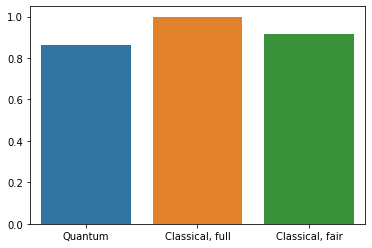

In [35]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])